# **P09 - Prédiction de la demande en électricité**

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from statsmodels.api import OLS
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

import locale
import unidecode
import timeit

In [2]:
# background des graphes: check
plt.style.use('bmh')
mpl.rcParams['axes.edgecolor'] = 'lightslategray'
mpl.rcParams['figure.facecolor'] = 'lightgrey'

### **Table des matières**  
  
[**1. Présentation des données**](#1-présentation-des-données)  
- [**1.1 Préparation des données**](#11-préparation-des-données)  
    - **1.1.1. Météo_brute**  
    - **1.1.2 Conso_brute**  
- [**1.2 Présentation des données**](#12-présentation-des-données)  
  
[**2. Chauffage et corrections**](#2-chauffage-et-corrections)  
- [**2.1 Préparation des données**](#21-préparation-des-données)  
- [**2.2 Correction des données**](#22-correction-des-données)
  
[**3. Saisonnalité**](#3-saisonnalité)  
  
[**4. Prévision de la consommation**](#4-prévision-de-la-consommation)  
- [**4.1 Méthode Holt-Winters**](#41-méthode-holt-winters)  
- [**4.2 Méthode SARIMA**](#42-méthode-sarima)  
    - **4.2.1 Stationnarité**  
    - **4.2.2 SARIMA**

#### [**1. Présentation des données**](#table-des-matières)

In [3]:
conso_brute = pd.read_csv('conso_mensuelle_energie.csv', sep = ';')
meteo_brute = pd.read_excel('meteo_dju.xlsx')

ParserError: Error tokenizing data. C error: Expected 1 fields in line 13, saw 8


##### [**1.1 Préparation des données**](#table-des-matières)  
  
Aperçus des dataframes brutes et nettoyage de printemps.  
  
[**o 1.1.1 Météo_brute**](#table-des-matières)  
  
On commence avec les premières vues, une éventuelle réorganisation et le nettoyage usuel (NaN, valeurs significatives).

In [ ]:
meteo_brute.shape

(24, 14)

In [ ]:
meteo_brute.head(2)

,Export DJU 14/07/2022,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Station météo,NaN,PARIS-MONTSOURIS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# extraction des pseudo-metadonnées sur la consommation
meta_meteo = meteo_brute.iloc[:6, [0, 2]].dropna()
meta_meteo.columns = ['dju', 'valeur']
meta_meteo

,dju,valeur
1,Station météo,PARIS-MONTSOURIS
2,Usage,Chauffage
3,Méthode de calcul,Professionnels de l'énergie
4,Température de référence,18°C
5,Date de début,2009-01-01 15:41:34.187000


En cas de besoin, nous choisissons de conserver ses indications sur le contexte d'acquisition des données de consommation énergétique.  
2 informations capitales sont à retenir:  
- les relevés concernent la capitale;  
- le DJU est en base 18.

In [ ]:
# extraction des DJU
dju_ = meteo_brute.iloc[7:]
dju_.head()

,Export DJU 14/07/2022,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Résultats,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,JAN,FÉV,MAR,AVR,MAI,JUN,JUI,AOÛ,SEP,OCT,NOV,DÉC,Total
11,2021,396.7,303.3,276.5,232.2,147.1,7.9,0,0,0,0,0,0,1363.6


In [ ]:
# renommage des colonnes  en utilisant les valeurs de la ligne "10"
dju_.columns = dju_.loc[10]
dju_.reset_index(inplace = True, drop = True)

In [ ]:
# suppression des 3 premières lignes aux valeurs NaN
dju = dju_.iloc[4:]

In [ ]:
# réduction de la casse des noms de colonnes
dju.columns = dju.columns.str.lower()

In [ ]:
# noms de colones: traitement des accents et nom en NaN
dju.columns = ['annee', 'janv.', 'févr.', 'mars', 'avr.', 'mai', 'juin', 'juil.', 'août', 'sept.', 'oct.', 'nov.', 'déc.', 'tot']

In [ ]:
# nettoyage des NaN?
dju.isna().any().any()

False

In [ ]:
# valeurs non sigificatives?
dju.dtypes

annee    object
janv.    object
févr.    object
mars     object
avr.     object
mai      object
juin     object
juil.    object
août     object
sept.    object
oct.     object
nov.     object
déc.     object
tot      object
dtype: object

- Le df ne contient que des chiffres apparents or dtypes = objet => il s'agit de chaîne de caractères => à convertir.

In [ ]:
dju = dju.convert_dtypes()

In [ ]:
# utilisation des années en tant qu'index
dju.set_index('annee', inplace = True)

In [ ]:
dju

,janv.,févr.,mars,avr.,mai,juin,juil.,août,sept.,oct.,nov.,déc.,tot
annee,,,,,,,,,,,,,
2021,396.7,303.3,276.5,232.2,147.1,7.9,0.0,0.0,0.0,0.0,0.0,0.0,1363.6
2020,339.0,249.6,269.2,105.6,85.9,37.7,16.5,12.6,46.1,158.9,227.7,336.8,1885.6
2019,404.9,268.8,234.3,177.2,126.8,35.7,10.0,11.8,45.3,136.9,282.6,327.3,2061.8
2018,303.4,432.6,314.4,128.9,74.1,20.1,1.6,13.5,53.7,133.4,282.8,325.9,2084.2
2017,467.9,278.4,208.9,187.1,87.8,21.4,13.5,20.8,74.5,109.3,282.6,369.0,2121.2
2016,364.4,321.6,321.1,214.1,100.7,40.8,14.7,13.8,27.3,177.3,285.6,390.8,2271.9
2015,392.0,365.7,275.7,154.6,104.8,36.4,15.8,16.1,81.8,179.6,196.9,248.1,2067.5
2014,324.4,281.9,226.6,141.8,112.5,37.3,17.7,36.1,34.4,101.3,223.3,368.2,1905.3
2013,429.2,402.2,376.6,216.3,161.5,57.6,9.3,19.9,55.3,112.0,303.9,349.5,2493.2


**Observations succinctes:**  
- Les données s'étendent sur 12 ans;  
- La dernière année 2021 est incomplète: doit correspondre aux données à prédire;  
- Nous repérons les années les plus douces: 2014 et 2020 et la plus froide, 2010.

[**o 1.1.2 Conso_brute**](#table-des-matières)

In [ ]:
conso_brute.shape

(1523, 30)

In [ ]:
conso_brute.columns

Index(['Mois', 'Qualité', 'Territoire', 'Production totale',
       'Production nucléaire', 'Production thermique totale',
       'Production thermique charbon', 'Production thermique fioul',
       'Production thermique gaz', 'Production hydraulique',
       'Production éolien', 'Production solaire', 'Production bioénergies',
       'Consommation totale', 'Solde exportateur', 'Echanges export',
       'Echanges import', 'Echanges avec le Royaume-Uni',
       'Echanges avec l'Espagne', 'Echanges avec l'Italie',
       'Echanges avec la Suisse', 'Echanges avec l'Allemagne et la Belgique',
       'Pompage', 'Stockage batterie', 'Déstockage batterie',
       'Eolien terrestre', 'Eolien offshore', 'Unnamed: 27', 'Unnamed: 28',
       'Unnamed: 29'],
      dtype='object')

Flux énergétiques mensuels de toute nature par région; nous utilisons uniquement la consommation totale.

In [ ]:
conso_ = conso_brute[['Mois', 'Territoire', 'Consommation totale']]
conso_.columns = ['mois', 'region', 'conso_tot']

In [ ]:
conso_ = conso_[conso_.region == 'Ile-de-France']

In [ ]:
conso_.head(2)

,mois,region,conso_tot
43,01-janv.-13,Ile-de-France,NaN
56,01-févr.-13,Ile-de-France,NaN


In [ ]:
conso_.dtypes

mois          object
region        object
conso_tot    float64
dtype: object

Nous anticipons sur le nettoyage: les types de chaque colonne sont conforment aux attentes.  
Les prochaines étapes:  
- nous convertissons ces strings en datetime afin qu'ils soient plus manipulables;   
- nous regardons le comportement des individus NaN en observant notamment leur répartition: il y a des valeurs régionales et nationales or nous avons déjà fait un choix avec les DJU;  
- nous traitons les valeurs manquantes.  
  
**o Etape 1/3: conversion en datetime**

In [ ]:
conso = conso_[['region', 'conso_tot']].copy()

In [ ]:
# pour forcer la reconnaissance des mois en fr
locale.setlocale(locale.LC_ALL, 'fr_FR')

'fr_FR'

In [ ]:
# conversion str => datetime
conso['date'] = conso_['mois'].apply(lambda _: dt.datetime.strptime(_, "%d-%b-%y"))

In [ ]:
conso.head()

,region,conso_tot,date
43,Ile-de-France,NaN,2013-01-01
56,Ile-de-France,NaN,2013-02-01
69,Ile-de-France,NaN,2013-03-01
82,Ile-de-France,NaN,2013-04-01
95,Ile-de-France,NaN,2013-05-01


**o Etape 2/3: individus et valeurs NaN**

In [ ]:
# NaN?
conso.isna().any()

region       False
conso_tot     True
date         False
dtype: bool

In [ ]:
# liste des années
conso.date.dt.year.unique()

array([2013, 2014, 2015, 2019, 2020, 2021])

In [ ]:
# individus ayant une "conso_tot" = NaN
conso[conso.conso_tot.isna()]

,region,conso_tot,date
43,Ile-de-France,NaN,2013-01-01
56,Ile-de-France,NaN,2013-02-01
69,Ile-de-France,NaN,2013-03-01
82,Ile-de-France,NaN,2013-04-01
95,Ile-de-France,NaN,2013-05-01
108,Ile-de-France,NaN,2013-06-01
121,Ile-de-France,NaN,2013-07-01
134,Ile-de-France,NaN,2013-08-01
147,Ile-de-France,NaN,2013-09-01
160,Ile-de-France,NaN,2013-10-01


In [ ]:
# colonne "date" des individus NaNés
conso[conso.conso_tot.isna()].date.dt.year.unique()

array([2013])

Il y a 4 années de valeurs manquantes dont 3 totalement absentes.  
En 9 ans, les modes de consommation ont changé donc nous pouvons nous passer de 2013 mais nous avons besoins des trois autres années.  
Nous ne pouvons utiliser des méthodes d'imputation, les données seraient trop lissées et risqueraient de fausser les prédictions => nous allons devoir les recalculer à partir des données de Conso_brute.  
  
**o Etape 3/3: nettoyage**  
  
Conso_brute contient les données de tous les flux d'énergies (toute nature confondue). La consommation nationale de la France correspond à:  
flux entrant - flux sortant (hors conso) = production totale + importation + déstockage batterie - exportation - stockage batterie.  

In [ ]:
# travaille sur la portion à problème pour réduire les coûts de calculs
conso_nan = conso_brute[conso_brute['Consommation totale'].isna()].copy()

In [ ]:
conso_nan[conso_nan['Production totale'].isna()]['Echanges import'].unique()

array([nan])

Nous venons de vérifier le cas improbable où la France auraient eu une production nulle. Il devrait au moins y avoir des entrées d'énergie or ce n'est pas le cas => toute l'acquisition de données de ces trois années est compromise => nous devons utiliser une autre source d'informations.

In [ ]:
# utilisation des données annuelles nationales
conso_annee = pd.read_csv('conso_annuelle_energie.csv', sep = ';')

In [ ]:
conso_annee.shape

(149, 48)

In [ ]:
conso_annee.columns

Index(['Année', 'Qualité', 'Territoire', 'Production totale',
       'Production nucléaire', 'Production thermique totale',
       'Production thermique charbon', 'Production thermique fioul',
       'Production thermique gaz', 'Production hydraulique',
       'Production éolien', 'Production solaire', 'Production bioénergies',
       'Consommation totale', 'Grande industrie PME/PMI',
       'Energie, industrie et agriculture',
       'Agriculture et industrie agroalimentaire',
       'Energies et combustibles minéraux solides', 'Chimie et parachimie',
       'Construction automobile', 'Métallurgie et mécanique',
       'Minéraux et matériaux', 'Papier, carton', 'Sidérurgie',
       'Autres industries', 'Tertiaire, télécom et transports',
       'Transports et télécommunications', 'Tertiaire', 'Perte',
       'Particuliers professionnels', 'Particuliers', 'Professionnels',
       'Solde exportateur', 'Echanges export', 'Echanges import',
       'Echanges avec le Royaume-Uni', 'Echanges

In [ ]:
conso_annee.head()

,Année,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,...,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique,Pompage,Stockage batterie,Déstockage batterie,Eolien terrestre,Eolien offshore,Unnamed: 45,Unnamed: 46,Unnamed: 47
0,2012,Données définitives,France,541,404.0,48.0,17.0,6.0,24.0,63.0,...,17.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013,Données définitives,Grand-Est,104,78.0,11.0,7.0,0.0,4.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013,Données définitives,Nouvelle-Aquitaine,50,41.0,0.0,0.0,0.0,0.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013,Données définitives,Auvergne-Rhône-Alpes,125,88.0,1.0,0.0,0.0,0.0,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013,Données définitives,Bourgogne-Franche-Comté,2,0.0,1.0,0.0,0.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# sélection des variables et des individus "ïle-de-France"
conso_an_idf = conso_annee[conso_annee['Territoire'] == 'Ile-de-France'][['Année', 'Territoire', 'Consommation totale']]

In [ ]:
conso_an_idf.isna().any()

Année                  False
Territoire             False
Consommation totale     True
dtype: bool

Seules nous intéressent les colonnes "Année", "Territoire" et "Consommation totale". Regardons les variables des individus à la consommation NaN.

In [ ]:
conso_an_idf[conso_an_idf['Consommation totale'].isna()]

,Année,Territoire,Consommation totale
8,2013,Ile-de-France,NaN


Les données manquantes ne concernent que l'année 2013 que nous avons déjà choisie d'écarter.  
Maintenant, nous devons vérifier que toutes les années "problématiques" sont présentes. Ensuite, nous rappelons que nous avons ici, des données annuelles dÎle-de-France. Nous nous appuyons sur les variations de DJU afin d'obtenir les approximations des valeurs mensuelles.

In [ ]:
# vérification des années
conso_an_idf["Année"].unique()

array([2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)

Procédure interrompue: des données complètes concernant l'Île-de-France sont tombées d'un "nuage" donc nous les utilisons pour l'étude des séries temporelles. Il s'agit de données de consommations brutes, par conséquent, elles représentent un terrain d'entraînement parfait pour ce projet.

In [ ]:
conso_idf_brute = pd.read_csv('data_elc_idf.csv', sep = ';')
conso_idf_brute.head(1)

,Mois,Code INSEE région,Région,Production totale (MWh),Pompage (MWh),Solde échanges physiques (MWh),Consommation brute (MWh),Géo-shape région,Géo-point région
0,2014-06,11,Île-de-France,149171.0,NaN,-4666061.0,4815232.0,"{""coordinates"": [[[2.9366236841, 48.1634557975...","48.7093154,2.503402421"


In [ ]:
conso_idf_brute.shape

(96, 9)

In [ ]:
conso_idf_brute.columns

Index(['Mois', 'Code INSEE région', 'Région', 'Production totale (MWh)',
       'Pompage (MWh)', 'Solde échanges physiques (MWh)',
       'Consommation brute (MWh)', 'Géo-shape région', 'Géo-point région'],
      dtype='object')

Le dataset contient moins d'informations sur les différents flux d'énergie mais les principales variables dont nous avons besoins sont présentent: "année" et "conso. tot.".

In [ ]:
conso_idf_ = conso_idf_brute[['Mois', 'Consommation brute (MWh)']]

In [ ]:
conso_idf_.dtypes

Mois                         object
Consommation brute (MWh)    float64
dtype: object

Nous devons convertir la variable "Mois" en datetime.

In [ ]:
conso_idf = conso_idf_[['Consommation brute (MWh)']]

In [ ]:
conso_idf['date'] = conso_idf_['Mois'].apply(lambda _: dt.datetime.strptime(_, "%Y-%m"))

In [ ]:
conso_idf.isna().any()

Consommation brute (MWh)    False
date                        False
dtype: bool

In [ ]:
# présence dans les variables, de valeurs non significatives?
conso_idf.dtypes

Consommation brute (MWh)           float64
date                        datetime64[ns]
dtype: object

In [ ]:
# changement ed psiion de la colonne "date"
conso_idf.insert(0, "date", conso_idf.pop('date'))

In [ ]:
conso_idf.rename(columns = {"Consommation brute (MWh)":"conso_mwh"}, inplace = True)

In [ ]:
conso_idf.head(2)

,date,conso_mwh
0,2014-06-01,4815232.0
1,2015-02-01,7579139.0


##### [**1.2 Présentation des données**](#table-des-matières)  
  
**Rappel:**  
Nous avons deux datasets concernant l'Île-de-France. L'un réunit les djus et l'autre, les consommations d'énergie de 2014 à 2021.  
Dans cette partie, nous abordons la première phase d'exploitation des données sur la consommation: l'exploration.

In [ ]:
# mesures générales
conso_idf.conso_mwh.describe()

count    9.600000e+01
mean     5.836721e+06
std      1.204286e+06
min      4.019415e+06
25%      4.819540e+06
50%      5.535340e+06
75%      6.751996e+06
max      8.894656e+06
Name: conso_mwh, dtype: float64

Le niveau de la série temporelle des consommations est 1 204 286 MWh.

In [ ]:
# mesures annuelles
conso_idf.groupby(conso_idf.date.dt.year).describe()

date                                                                 \
     count                 mean                  min                  25%   
date                                                                        
2014    12  2014-06-16 12:00:00  2014-01-01 00:00:00  2014-03-24 06:00:00   
2015    12  2015-06-16 12:00:00  2015-01-01 00:00:00  2015-03-24 06:00:00   
2016    12  2016-06-16 08:00:00  2016-01-01 00:00:00  2016-03-24 06:00:00   
2017    12  2017-06-16 12:00:00  2017-01-01 00:00:00  2017-03-24 06:00:00   
2018    12  2018-06-16 12:00:00  2018-01-01 00:00:00  2018-03-24 06:00:00   
2019    12  2019-06-16 12:00:00  2019-01-01 00:00:00  2019-03-24 06:00:00   
2020    12  2020-06-16 08:00:00  2020-01-01 00:00:00  2020-03-24 06:00:00   
2021    12  2021-06-16 12:00:00  2021-01-01 00:00:00  2021-03-24 06:00:00   

                                                                          \
                      50%                  75%                  max  std   
date                                                                       
2014  2014-06-16 00:00:00  2014-09-08 12:00:00  2014-12-01 00:00:00  NaN   
2015  2015-06-16 00:00:00  2015-09-08 12:00:00  2015-12-01 00:00:00  NaN   
2016  2016-06-16 00:00:00  2016-09-08 12:00:00  2016-12-01 00:00:00  NaN   
2017  2017-06-16 00:00:00  2017-09-08 12:00:00  2017-12-01 00:00:00  NaN   
2018  2018-06-16 00:00:00  2018-09-08 12:00:00  2018-12-01 00:00:00  NaN   
2019  2019-06-16 00:00:00  2019-09-08 12:00:00  2019-12-01 00:00:00  NaN   
2020  2020-06-16 00:00:00  2020-09-08 12:00:00  2020-12-01 00:00:00  NaN   
2021  2021-06-16 00:00:00  2021-09-08 12:00:00  2021-12-01 00:00:00  NaN   

     conso_mwh                                                         \
         count          mean          min           25%           50%   
date                                                                    
2014      12.0  5.843323e+06  4355003.000  4.885418e+06  5.466292e+06   
2015      12.0  6.011671e+06  4437269.000  4.943874e+06  5.791386e+06   
2016      12.0  6.085717e+06  4449939.000  4.914478e+06  5.914514e+06   
2017      12.0  5.943686e+06  4342666.000  4.883213e+06  5.462126e+06   
2018      12.0  5.899718e+06  4387227.812  4.867695e+06  5.416467e+06   
2019      12.0  5.800663e+06  4193740.000  4.752460e+06  5.516782e+06   
2020      12.0  5.418653e+06  4267662.000  4.396182e+06  5.103490e+06   
2021      12.0  5.690334e+06  4019415.000  4.546814e+06  5.515872e+06   

                                               
               75%          max           std  
date                                           
2014  6.569498e+06  7847171.000  1.140744e+06  
2015  6.894663e+06  8361518.000  1.249483e+06  
2016  7.158739e+06  7905796.000  1.256829e+06  
2017  6.687160e+06  8894656.000  1.367665e+06  
2018  7.108810e+06  7694216.033  1.236578e+06  
2019  6.656775e+06  8089751.000  1.205268e+06  
2020  6.254679e+06  7540281.000  1.177715e+06  
2021  6.534911e+06  7797725.000  1.229054e+06

Au passage, nous remarquons que nous avons bien 12 mois par années. Les données de cette série temporelle ont bien été prises à intervalles réguliers et équitable.

In [ ]:
dju.head(8)

,janv.,févr.,mars,avr.,mai,juin,juil.,août,sept.,oct.,nov.,déc.,tot
annee,,,,,,,,,,,,,
2021,396.7,303.3,276.5,232.2,147.1,7.9,0.0,0.0,0.0,0.0,0.0,0.0,1363.6
2020,339.0,249.6,269.2,105.6,85.9,37.7,16.5,12.6,46.1,158.9,227.7,336.8,1885.6
2019,404.9,268.8,234.3,177.2,126.8,35.7,10.0,11.8,45.3,136.9,282.6,327.3,2061.8
2018,303.4,432.6,314.4,128.9,74.1,20.1,1.6,13.5,53.7,133.4,282.8,325.9,2084.2
2017,467.9,278.4,208.9,187.1,87.8,21.4,13.5,20.8,74.5,109.3,282.6,369.0,2121.2
2016,364.4,321.6,321.1,214.1,100.7,40.8,14.7,13.8,27.3,177.3,285.6,390.8,2271.9
2015,392.0,365.7,275.7,154.6,104.8,36.4,15.8,16.1,81.8,179.6,196.9,248.1,2067.5
2014,324.4,281.9,226.6,141.8,112.5,37.3,17.7,36.1,34.4,101.3,223.3,368.2,1905.3


Sur les huit dernières années, 2021 possède le mois ayant eu la plus faible consommation électrique tandis que 2017 possède le record des dépenses énergétiques. On remarquera que les consommations minimales restent, à vu d'oeil, dans le même ordre de grandeur (4 million de MWh) alors que les consommations maximales présentent de fortes variations d'une année à l'autre.  
  
Si l'on se réfère aux données DJU pour les périodes considérées, 2016 est l'année la plus froide. 2014 et 2020 sont les plus douces. Si les moyennes suivent la même tendance que ces observations, les consommations maximales ne sont pas cohérentes avec les DJU. Elles sont d'autant plus contre-intuitive que les DJU sont directement proportionnels aux différentielles de températures et que les valeurs extrêmes sont mensuelles. Ainsi, l'année la plus froide n'est pas celle ayant le record de consommation.  
  
Regardons le comportement globale de ces données.

In [ ]:
# réindexation des données pour manipulation visuelle
conso_idf.set_index('date', inplace = True)
conso_idf.sort_index(inplace = True)

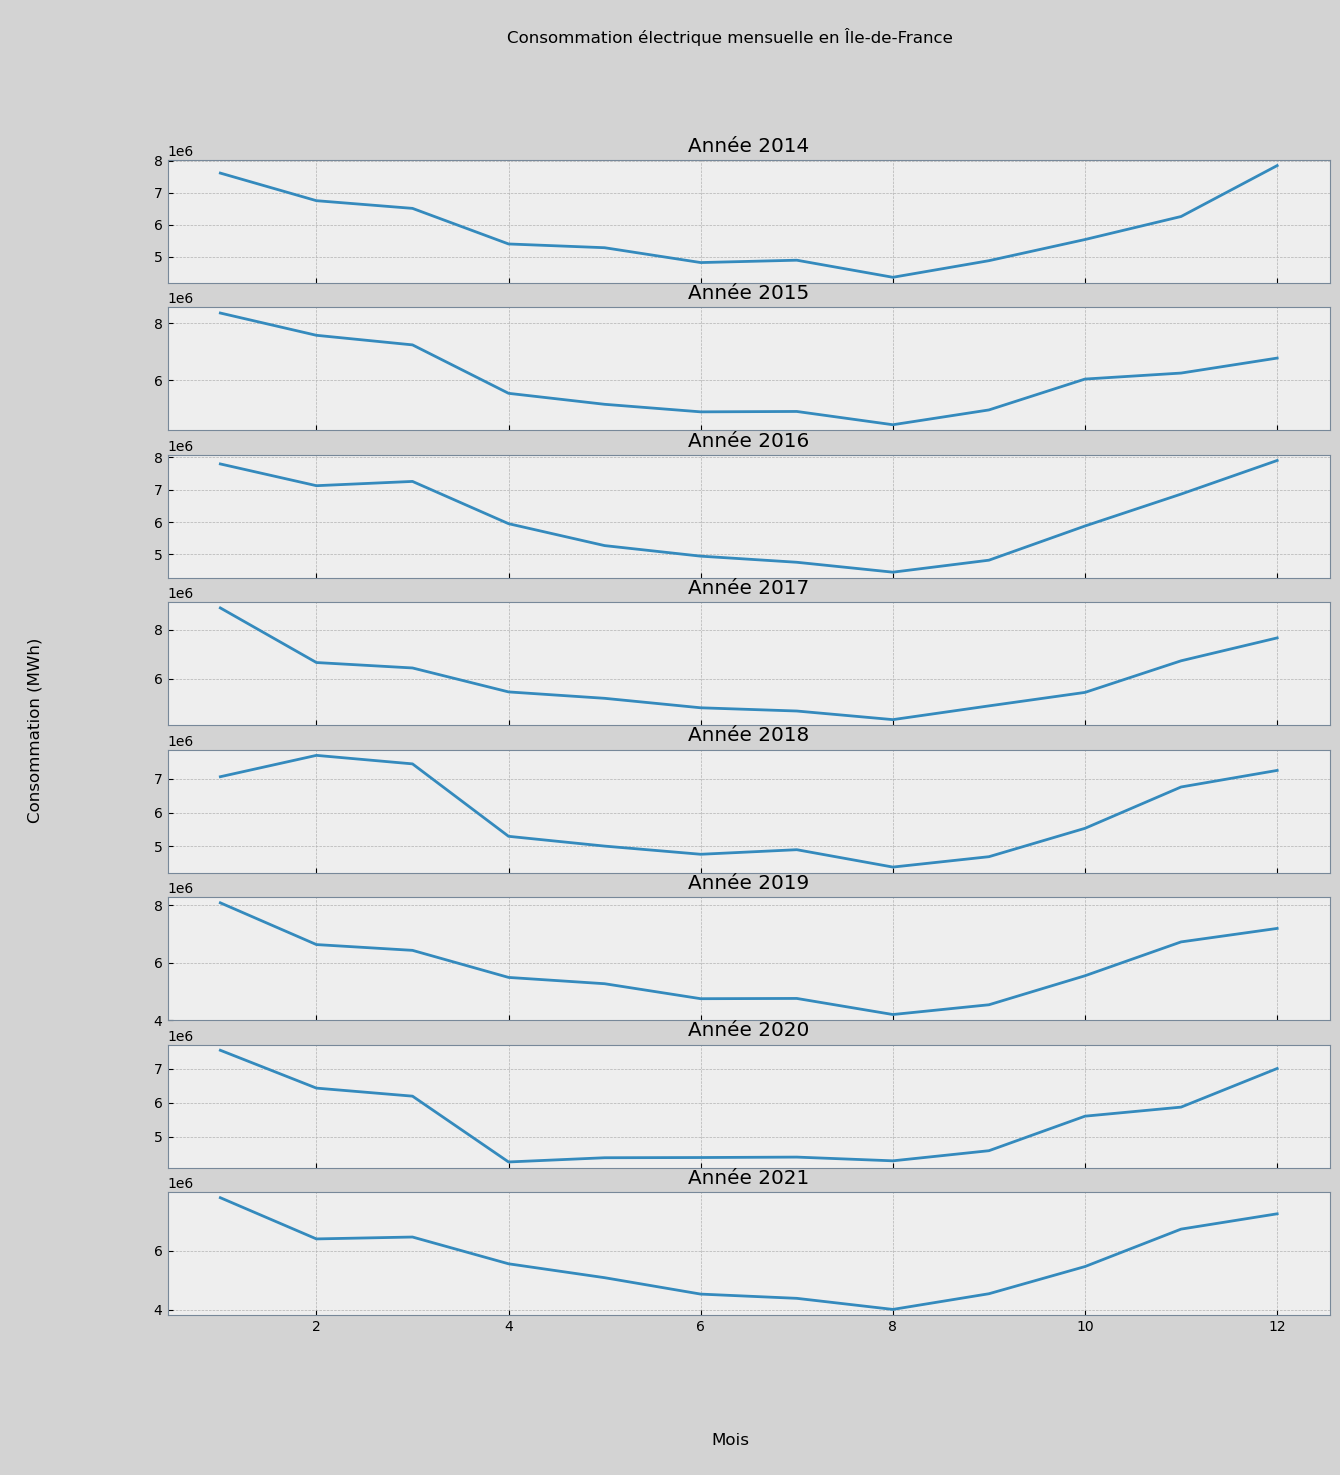

In [ ]:
# comparaison brute des années

# préparation du terrain
list_annee = conso_idf.index.year.unique().tolist()
taille = len(list_annee)
fig, ax = plt.subplots(8, 1, figsize = (15, 15))

# affichage pour chaque année
for i in range(taille):
    data = conso_idf[conso_idf.index.year == list_annee[i]]
    ax[i].plot(data.index.month, data.conso_mwh)
    ax[i].set_title('Année {}'.format(list_annee[i]))
    ax[i].label_outer()

fig.suptitle('\nConsommation électrique mensuelle en Île-de-France\n\n')
fig.supxlabel('Mois\n')
fig.supylabel('\nConsommation (MWh)')
plt.show()

**Observations**  
- Tous les mois présentent deux phases. L'une hivernale dont les niveaux de consommations sont les plus importants et la deuxième, estivale dont l'utilisation est minimale. Ces profils sont en accord avec le comportement de la société, les départs en vacances et les baisses d'activités des entreprises pouvant expliquer ces tendances.  
- Parmi le phase hivernale, nous avons également deux profils distincts.  
Dans le premier profil, illustré avec les années 2018 et 2020, la consommation est élevée pendant une courte période (environ 3 mois) jusqu'à une cassure nette dans la distribution par rapport à la période de chauffe.  
A l'opposé, le deuxième profil possède une distribution en forme d'escalier et décroît lentement sur une période deux fois plus longue que le premier groupe.

<Figure size 1500x2000 with 0 Axes>

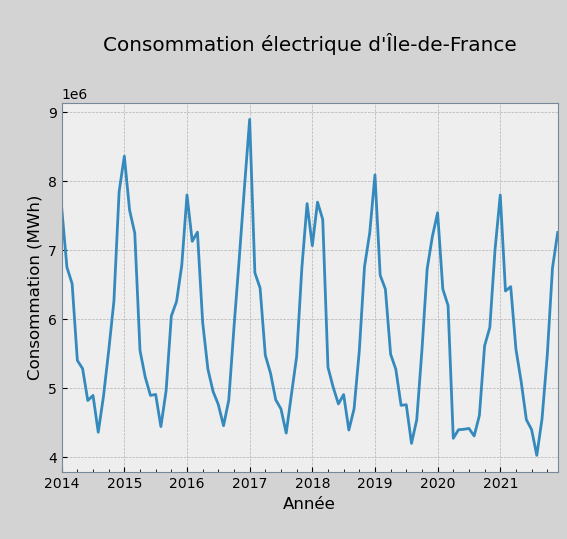

In [ ]:
# visualisation générale
plt.figure(figsize = (15, 20))
conso_idf.plot()
plt.title("\nConsommation électrique d'Île-de-France\n\n")
plt.xlabel('Année\n')
plt.ylabel('\nConsommation (MWh)')
plt.legend().set_visible(False)
plt.show()

**Observations**  
Pour rappel, la consommation électrique d'Île-de-France est au pas mensuel. Son évolution ne présente pas de tendance mais l'on y observe un schéma saisonnier annuelle évident et très marqué causé par les températures hivernales et le rythme de vie de la société. Un cycle de deux à trois ans peut s'observer durant lesquelles la distribution annuelle est bimodale, ici nous avons 2016, 2018 et 2021. De plus, un phénomène irrégulier est observé entre 2020 et 2021, la distribution est donc légèrement bruité.  
Enfin, puisque l'effet saisonnier ne change pas avec le temps, la consommation suit donc un modèle additif.

<Figure size 2000x2000 with 0 Axes>

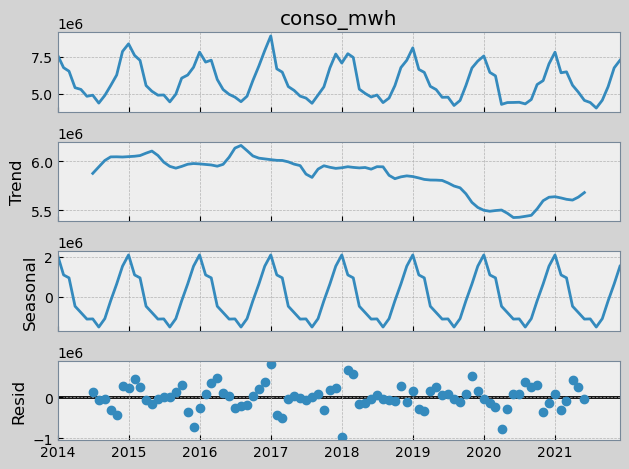

In [ ]:
# décomposition de la consommation
conso_decompo = seasonal_decompose(conso_idf.conso_mwh, model = 'additive')
plt.figure(figsize = (20, 20))
fig = conso_decompo.plot()

La décomposition automatique présente une légère tendance baissière à partir de 2017 qui repart à la hausse courant 2020, cette période coïncide avec la fin du première confinement sanitaire. La composante saisonnière ne présente pas d'irrégularité et l'amplitude des périodes est constant au cours des années. Cette série temporelle repose donc sur un modèle additif.

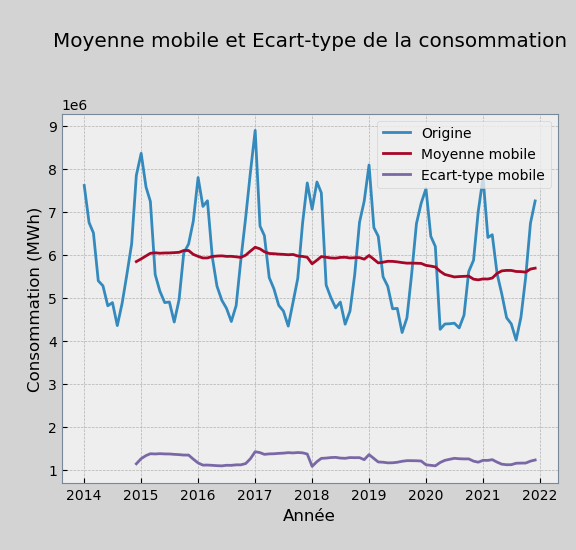

In [ ]:
# test sur la stationnarité
rolling_mean = conso_idf.rolling(window = 12).mean()
rolling_std = conso_idf.rolling(window = 12).std()

plt.plot(conso_idf, label = 'Origine')
plt.plot(rolling_mean, label = 'Moyenne mobile')
plt.plot(rolling_std, label = 'Ecart-type mobile')

plt.xlabel('Année\n')
plt.ylabel('\nConsommation (MWh)')
plt.title('\nMoyenne mobile et Ecart-type de la consommation\n\n')
plt.legend().set_visible(True)
plt.show()

L'écart-type et la moyenne mobile sont stables au cours du temps mais la moyenne mobile observe une tendance légèrement baissière à partir de 2020 => nous ne pouvons conclure au caractère stationnaire de la consommation électrique d'Île-de-France. Un test sera effectué par la suite si les besoins sont requis.  
Nous voulons utiliser ces données pour prévoir les consommations futures. Deux problèmes se présentent:  
- Pour entrainer notre estimateur, nous devons utiliser une base neutre vierge de tout effet qui ne soit pas réellement significatif, ie qui ne dépend pas du phénomène lui-même mais de son environnement, dans ce cas-ci, la saisonnalité en est un;  
- Les DJU utilisés pour corriger cet effet de saison ne sont pas officialisés au-delà de la mi-année 2021 => nous n'utiliserons pas les données de consommations sur cet intervalle.

#### [**2. Chauffage et corrections**](#table-des-matières)  
  
Nous devons supprimer les variations imputables au climat afin de ramener la consommation sur un seuil de comparaison équitable. Nous utilisons les DJU afin de calculer ces valeurs selon la formule:  
$consommation_{corrigée} = consommation_{brute}$ x $\frac{DJU_{réf}}{DJU_{locale}}$, $DJU_{réf}$ = 2500.  
  
Nous commençons par préparer nos données pour les besoins locaux puis nous corrigeons les données des effets du climat.  
  
##### [**2.1 Préparation des données**](#table-des-matières)

In [ ]:
conso_idf.head(2)

,conso_mwh
date,
2014-01-01,7612497.0
2014-02-01,6749845.0


In [ ]:
dju.head(2)

,janv.,févr.,mars,avr.,mai,juin,juil.,août,sept.,oct.,nov.,déc.,tot
annee,,,,,,,,,,,,,
2021,396.7,303.3,276.5,232.2,147.1,7.9,0.0,0.0,0.0,0.0,0.0,0.0,1363.6
2020,339.0,249.6,269.2,105.6,85.9,37.7,16.5,12.6,46.1,158.9,227.7,336.8,1885.6


Avant d'utiliser les DJU, nous retravaillons son format pour le rendre plus malléable et permettre les correspondances vectorielles. Une présélection des 8 premières lignes des DJU est faite pour ne sélectionner que les dates utiles, ie, les huit dernières années. Puis, nous convertissons les variables "années" et "mois" en datetime. Le dataframe "df" est utilisé pour les opérations intermédiaires. 

In [ ]:
# sélection des 12 premières colonnes (mois) et des 8 premières lignes (années)
df = dju.iloc[:, :12].head(8).stack()

In [ ]:
# ré-initilisation du df
df = df.to_frame().reset_index()
df.columns = ['annee', 'mois', 'valeur']

In [ ]:
# rétro-conversion en string pour utilisation de la prochaine fonction (agg)
df.annee = df.annee.astype(str)

In [ ]:
# fusion des années et des mois
df['an_mois'] = df[['annee', 'mois']].agg('-'.join, axis = 1)

In [ ]:
df.head(2)

,annee,mois,valeur,an_mois
0,2021,janv.,396.7,2021-janv.
1,2021,févr.,303.3,2021-févr.


In [ ]:
dju = df[['valeur']].copy()

In [ ]:
# conversion des strigs en datetime [année-mois]
dju['date'] = df['an_mois'].apply(lambda _: dt.datetime.strptime(_, "%Y-%b"))

In [ ]:
# indexation des datetimes
dju.set_index('date', inplace = True)
dju.head(2)

,valeur
date,
2021-01-01,396.7
2021-02-01,303.3


Les dataframes sont prêts, nous passons à la correction.  
  
##### [**2.2 Correction des données**](#table-des-matières)  
  
Nous appliquons la formule de correction. Pour plus de visibilité, nous calculons le coefficient des dju en premier puis son produit à la consommation brute.  
Nous rappelons que les 7 derniers mois de 2021 ne sont pas utilisables à cause de l'absence des dju correspondant.

In [ ]:
quotient = 2500 / dju

In [ ]:
# présence de valeurs inf. à cause des dju inexistants de 2021
quotient.replace(np.inf, 0, inplace = True)

In [ ]:
conso_idf['conso_corr'] = conso_idf.conso_mwh * quotient.valeur

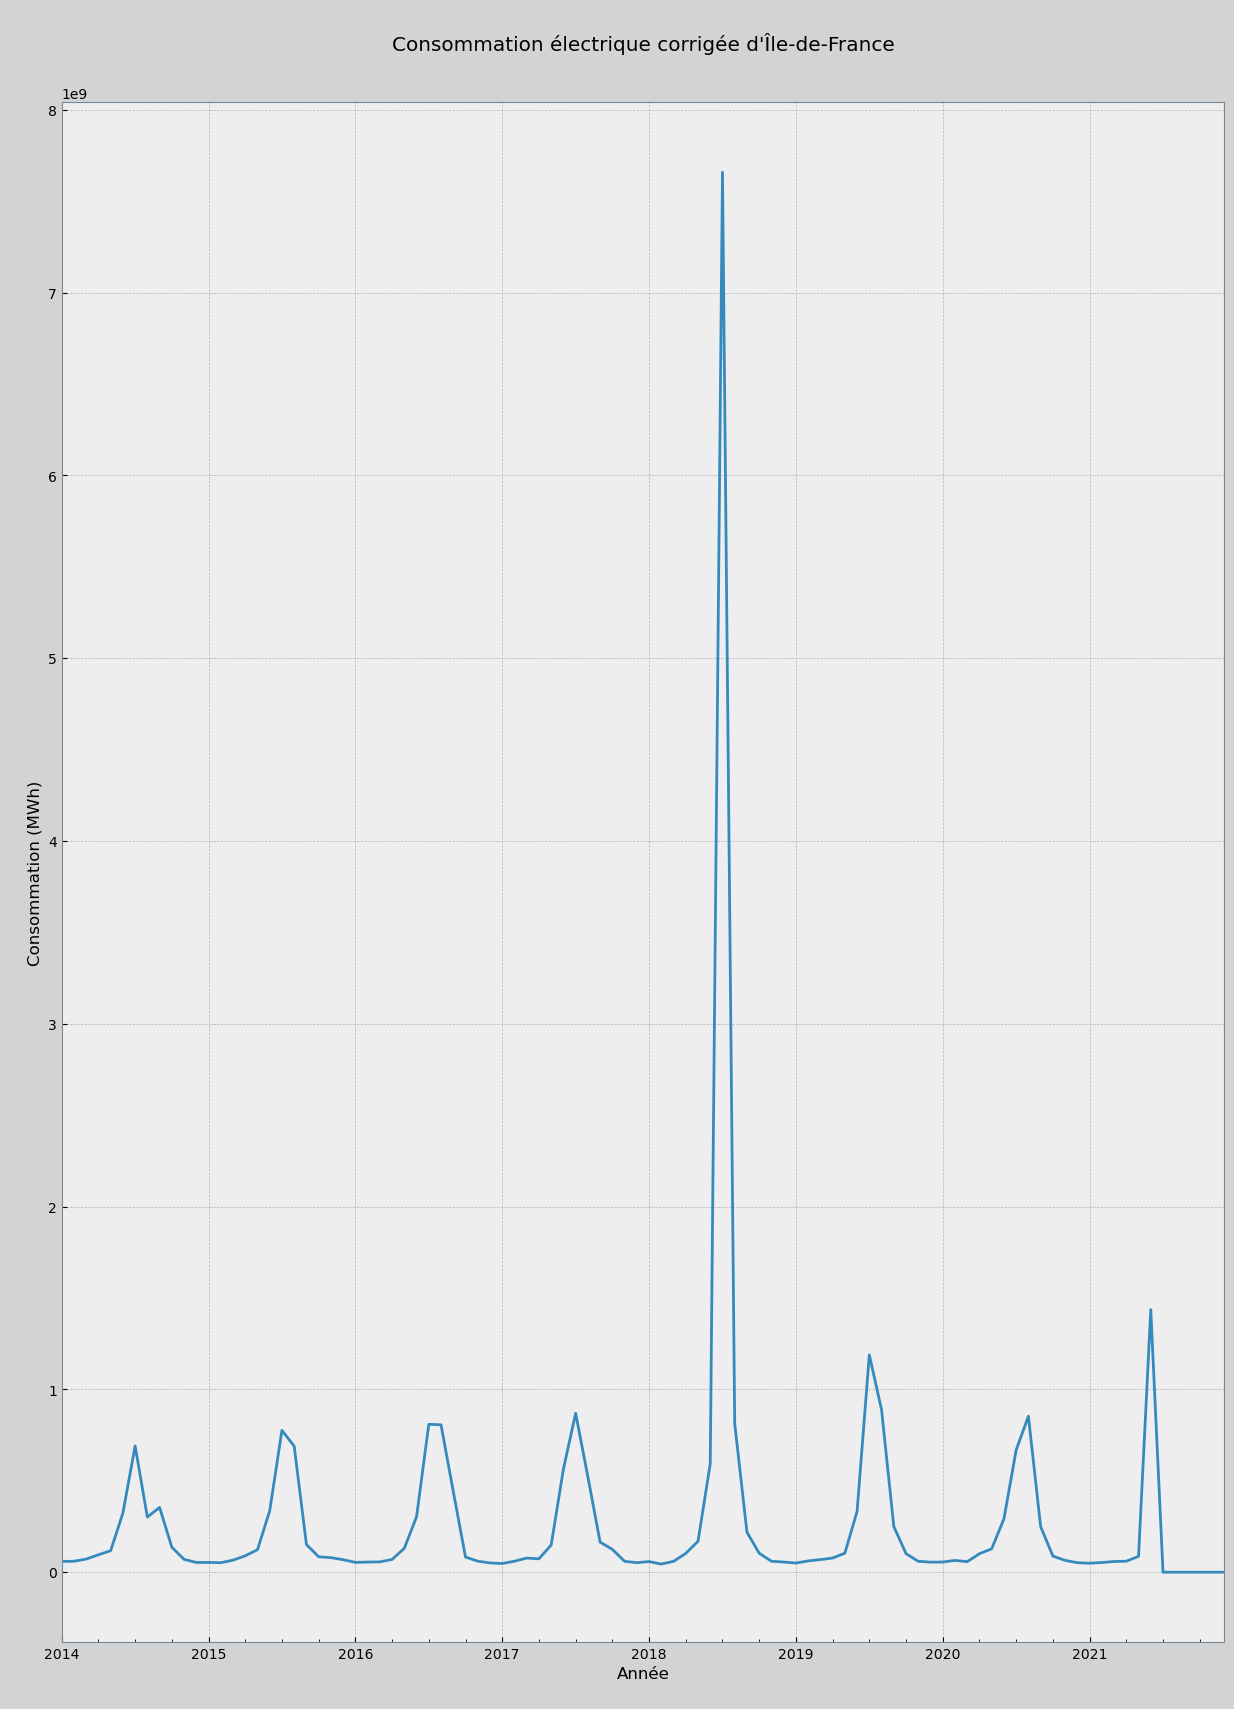

In [ ]:
# visualisation après suppression des effets du chauffage
plt.figure(figsize = (15, 20))
conso_idf.conso_corr.plot()
plt.title("\nConsommation électrique corrigée d'Île-de-France\n\n")
plt.xlabel('Année\n')
plt.ylabel('\nConsommation (MWh)')
plt.show()

Nous obtenons une série au profil saisonnier dominant ne présentant toujours pas de tendance à l'oeil nu mais ayant un outlier durant l'année 2018.  
On se souvient que la consommation de cette année n'est pas la plus importante mais fait partie des périodes "à haute densité" durant lesquelles, les DJU sont les plus élevés. Par conséquent, l'écart des températures minimales et maximales très important suscite une sensibilité accrue au froid entraînant une utilisation plus importante du chauffage or nous venons d'en corriger les effets.  
=> L'origine de cet outlier ne peut être dû au climat.  
=> Nous concentrons notre attention sur les consommations de 2018 dans un aparté afin de comprendre cette irrégularité.  
  
Prochaines actions:  
- nous confrontons la distribution des consommations de 2018 avec les autres années;  
- nous observons toutes les données digitales brutes de 2018; 
- nous effectuons les corrections/ajustements nécessaires.

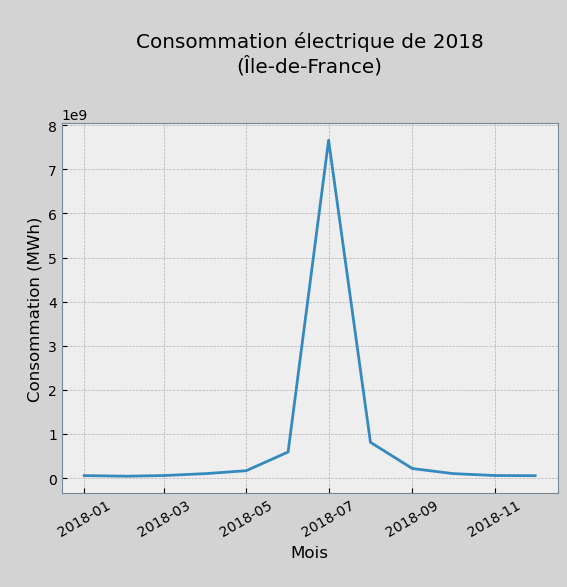

In [ ]:
# série temporelle de la consommation de 2018
df = conso_idf[conso_idf.index.year == 2018]
plt.plot(df.conso_corr)
plt.title('\nConsommation électrique de 2018\n(Île-de-France)\n\n')
plt.xlabel('Mois\n')
plt.ylabel('\nConsommation (MWh)')
plt.xticks(rotation = 30)
plt.show()

In [ ]:
list_annee.remove(2018)

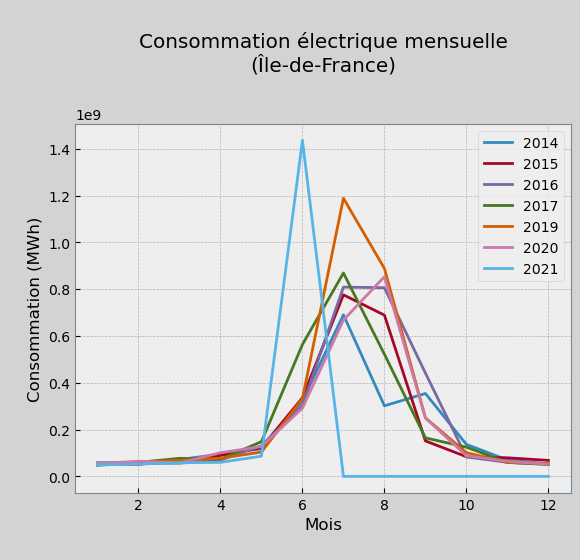

In [ ]:
# série temporelle unitaire pour toutes les années, 2018 exceptée
x = conso_idf.index.month.unique()

for annee in list_annee:
    y = conso_idf[conso_idf.index.year == annee]['conso_corr']
    plt.plot(x,y)

plt.legend(list_annee)
plt.title('\nConsommation électrique mensuelle\n(Île-de-France)\n\n')
plt.xlabel('Mois\n')
plt.ylabel('\nConsommation (MWh)')
plt.show()

Nous cherchons à comprendre le comportement de la consommation de 2018, sa distribution présente une forme en pic aux alentours des mois estivaux. Ce comportement est comparable aux autres années mais l'ordre de grandeurs du maximum est 5.7 fois plus grand. Aucunes données (mathématiques ou socio-éco) ne permet d'expliquer cette aberration.

In [ ]:
# aperçu de la consommation corrigée de 2018
conso_idf[conso_idf.index.year == 2018]

,conso_mwh,conso_corr
date,,
2018-01-01,7062105.709,58191378.617337
2018-02-01,7694216.033,44464956.270227
2018-03-01,7442373.863,59179181.480598
2018-04-01,5297923.135,102752582.137316
2018-05-01,5008145.850,168965784.412955
2018-06-01,4766212.999,592812562.064677
2018-07-01,4901522.314,7658628615.625
2018-08-01,4387227.812,812449594.814815
2018-09-01,4694508.471,218552535.893855


Chaque valeur de la consommation corrigée a 6 chiffres significatifs exceptée juillet qui est le mois "aberrant" de la distribution or sa valeur d'origine est du même ordre que les autres mois. La source de cette valeur aberrante doit résider dans les DJU.

In [ ]:
dju[dju.index.year == 2018]

,valeur
date,
2018-01-01,303.4
2018-02-01,432.6
2018-03-01,314.4
2018-04-01,128.9
2018-05-01,74.1
2018-06-01,20.1
2018-07-01,1.6
2018-08-01,13.5
2018-09-01,53.7


Le DJU du mois de juillet est anormalement bas surtout pour un mois estival.  
Il y a une forte probabilité qu'une erreur d'acquisition ait eu lieu => nous choisissons de modifier sa valeur et de la multiplier par 10 afin de la ramener dans les normes.  
Ensuite, nous recalculons la consommation corrigée de juillet 2018.  
Rappel de la formule de conso. corrigée:  
$consommation_{corrigée} = consommation_{brute}$ x $\frac{DJU_{réf}}{DJU_{locale}}$, $DJU_{réf}$ = 2500  
  
Puis nous profitons de cette aparté pour supprimer les individus des mois de juin 2021 à décembre 2021 qui ne sont statistiquement pas exploitables puisque les DJU ne sont officiellement pas validés pour cette période.

In [ ]:
# affectation de la nouvelle valeur du dju de juillet 2018
dju.loc[(dju.index.year == 2018) & (dju.index.month == 7), 'valeur'] = 1.6 * 10

In [ ]:
# calcul du quotient des DJU
quotient_juillet2018 = 2500 / dju[(dju.index.year == 2018) & (dju.index.month == 7)].valeur

In [ ]:
# calcul du produit pour la conso. corrigée pour juillet 2018
nouvelle_val = conso_idf[(conso_idf.index.year == 2018) & (conso_idf.index.month == 7)].conso_mwh * quotient_juillet2018

In [ ]:
# affectation de la nouvelle valeur de juillet 2018
conso_idf.loc[(conso_idf.index.year == 2018) & (conso_idf.index.month == 7), 'conso_corr'] = nouvelle_val

In [ ]:
# suppression et conservation des mois obsolètes de 2021
obsolete_2021 = conso_idf[(conso_idf.index.year == 2021) & (conso_idf.index.month > 5)]
idx = conso_idf[(conso_idf.index.year == 2021) & (conso_idf.index.month > 5)].index
conso_idf.drop(idx, inplace = True)

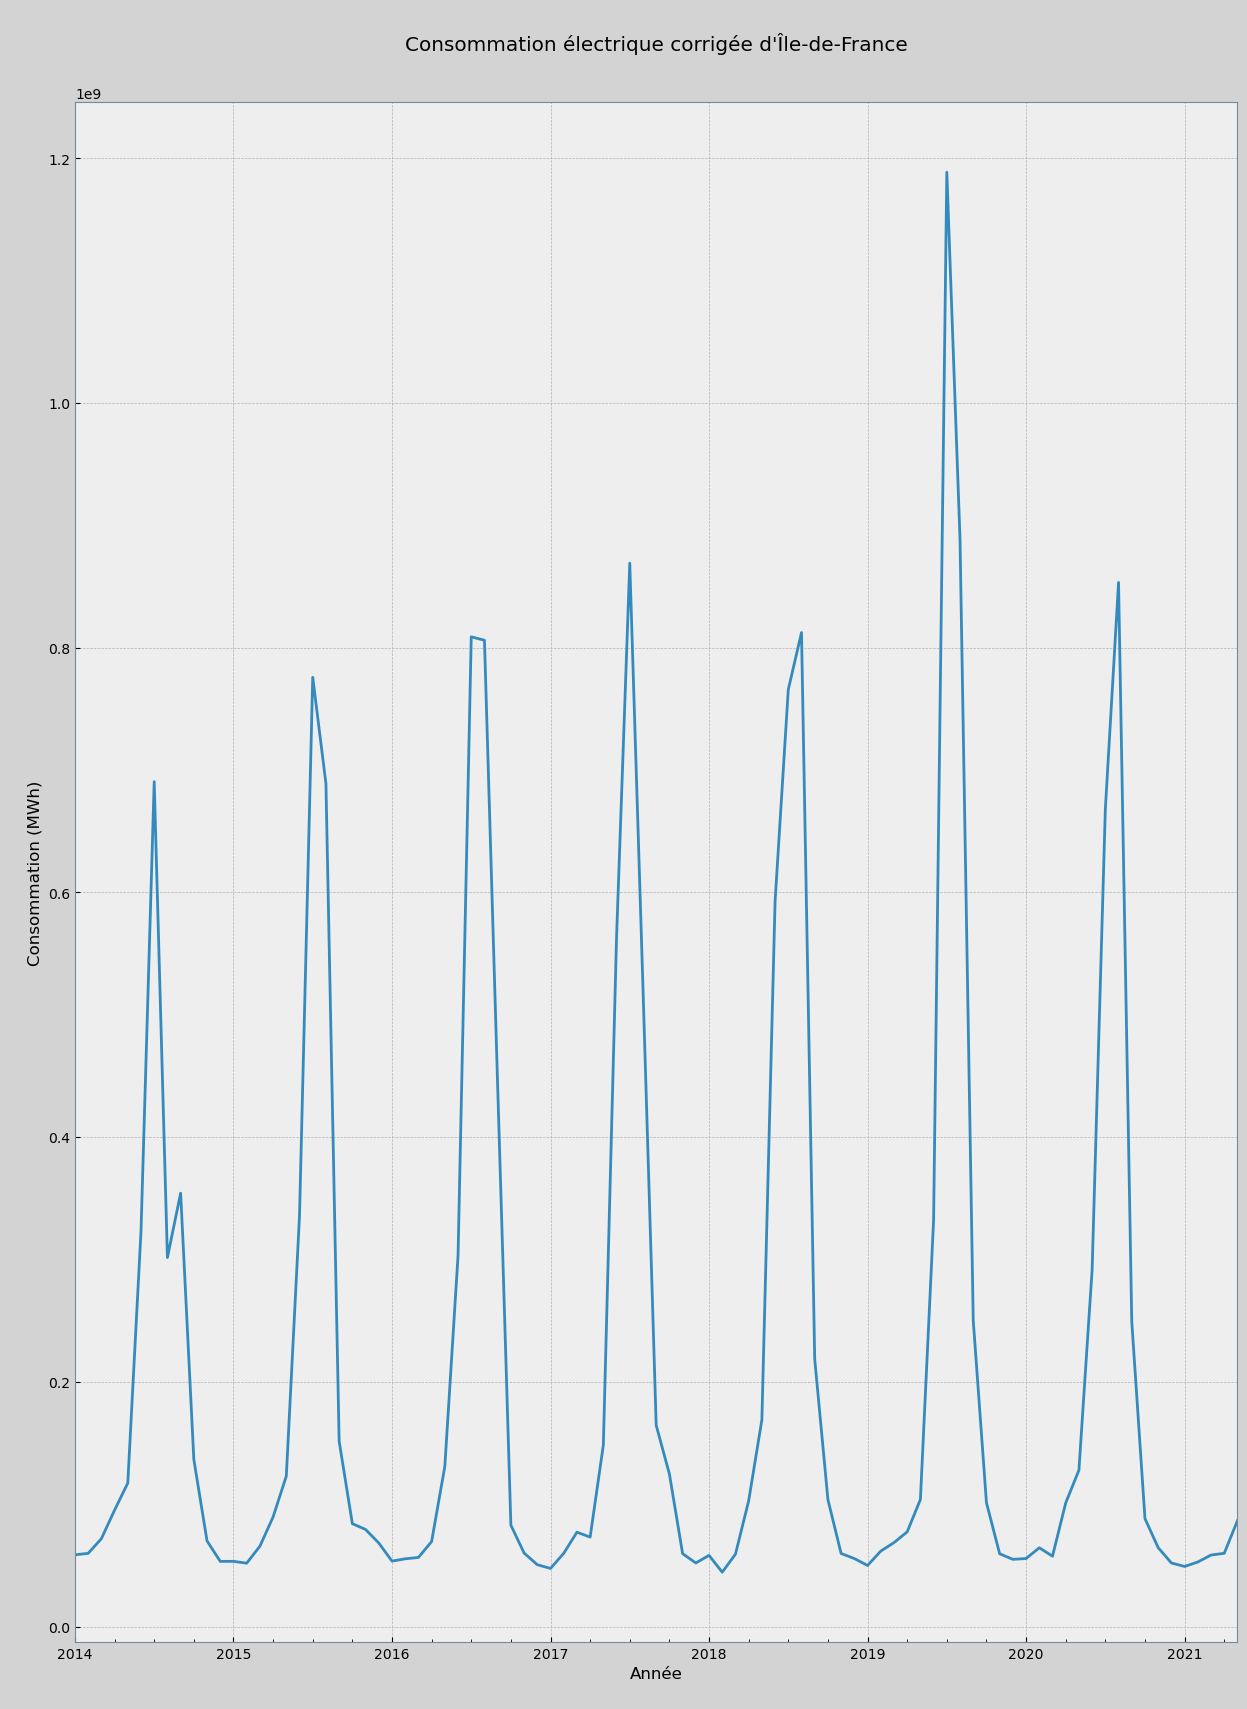

In [ ]:
# visualisation après suppression des effets du chauffage et correction
plt.figure(figsize = (15, 20))
conso_idf.conso_corr.plot()
plt.title("\nConsommation électrique corrigée d'Île-de-France\n\n")
plt.xlabel('Année\n')
plt.ylabel('\nConsommation (MWh)')
plt.show()

La consommation de 2018 est à présent dans les normes mais cette fois-ci, celle de 2019 est bien plus importante mais n'est pas aberrante. Sa valeur reste dans le même ordre de grandeur que les autres années. Elle traduit davantage une augmentation réelle et localisée dans le temps de la consommation électrique en Île-de-France que la présence d'une anomalie.

Nous en étions à la représentation de la consommation sans les effets de chauffage. Nous obtenons une distribution saisonnière évidente.  
  
A présent, nous devons déterminer la corrélation entre les dju et le chauffage. Nous commençons par joindre les deux df en utilisant les dates comme clef de jointure puis nous faisons une représentation graphique du chauffage en fonction des dju.

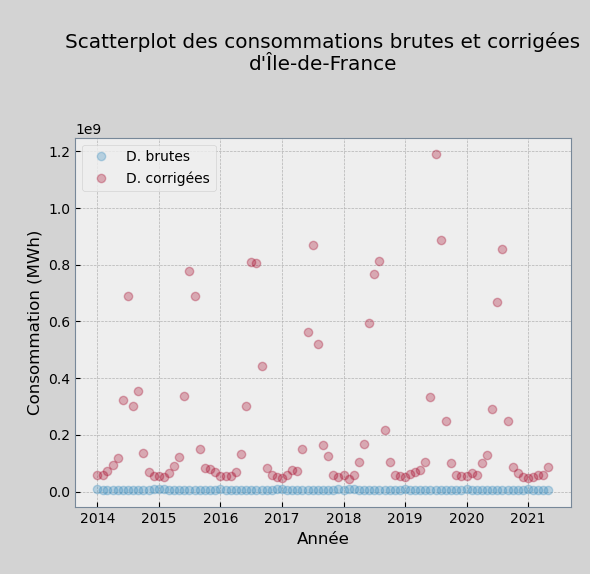

In [ ]:
# scatterplot des données brutes et corrigées
plt.plot(conso_idf.index, conso_idf.conso_mwh, 'o', alpha = 0.3)
plt.plot(conso_idf.index, conso_idf.conso_corr, 'o', alpha = 0.3)

plt.title("\nScatterplot des consommations brutes et corrigées\nd'Île-de-France\n\n")
plt.xlabel('Année\n')
plt.ylabel('\nConsommation (MWh)')
plt.legend(['D. brutes', 'D. corrigées'])
plt.show()

In [ ]:
# conversion Float64 en float64
conso_idf.conso_corr = conso_idf.conso_corr.astype(float)

In [ ]:
# création de dates numériques pour la régression linéaire
conso_idf['date_n'] = conso_idf.index.map(dt.datetime.toordinal)

In [ ]:
# déplacement de la colone "date_n"
conso_idf.insert(1, "date_n", conso_idf.pop("date_n"))

In [ ]:
# préparation des données ave
x = np.array(conso_idf.date_n)
y = np.asarray(conso_idf.conso_corr)

x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

In [ ]:
# entraîntement de la modélisation
model_rl = LinearRegression()
model_rl.fit(x, y)

LinearRegression()

In [ ]:
# prédiction des consommations
conso_predit = model_rl.predict(x)

#### [**3. Saisonnalité**](#table-des-matières)  
  
Nous devons supprimer les effets de saison induits par le climat. Nous appliquons la méthode des moyennes mobiles pour désaisonnaliser la consommation électrique.  
  
Plan:  
- calcul des moyennes mobiles;  
- calcul des coefficients de saisonnalité;  
- calcul des valeurs désaisonnalisées de la consommation;  
- graphiques de la consommation d'Île-de-France désaisonnalisée.

In [ ]:
conso_idf.head()

,conso_mwh,date_n,conso_corr
date,,,
2014-01-01,7612497.0,735234,5.866598e+07
2014-02-01,6749845.0,735265,5.986028e+07
2014-03-01,6509382.0,735293,7.181578e+07
2014-04-01,5396916.0,735324,9.515014e+07
2014-05-01,5279414.0,735354,1.173203e+08


La saisonnalité de la consommation possède une période de 12 mois donc afin d'en supprimer les effets, nous choisissons d'appliquer le calcul des moyennes mobiles à l'ordre 12.

In [ ]:
# calcul des moyennes mobiles
conso_idf['mm'] = conso_idf.conso_corr.rolling(12).mean()

In [ ]:
# calcul des coefficient de saisonnalité
conso_idf['coeff_mm'] = conso_idf.conso_corr / conso_idf.mm

In [ ]:
# calcul des coefficients de saisonnalité moyens pour chaque mois
coeff_moy = conso_idf.coeff_mm.groupby(conso_idf.index.month).mean()

In [ ]:
# sommation des coefficients moyens
coeff_moy.sum()

12.116732527176751

La somme des coefficients de saisonnalité doit être égale au nombre de mois soit 12 or la prise en compte des arrondissements lors des calculs rend la sommation incorrecte. Nous effectuons une correction puis affectons les valeurs correspondantes par mois au df principal "Conso_idf".

In [ ]:
coeff_moy_corr = coeff_moy * 12 / coeff_moy.sum()

In [ ]:
# affectation des coeff. ajustés dans le df principal
for i in coeff_moy_corr.index:
    conso_idf.loc[conso_idf.index.month == coeff_moy_corr.index[i-1], "coeff_ajus"] = coeff_moy_corr[i]

In [ ]:
# calcul des valeurs de la consommation désaisonnalisée
conso_idf["conso_dsais"] = conso_idf.conso_corr / conso_idf.coeff_ajus

In [ ]:
conso_idf.tail(2)

,conso_mwh,date_n,conso_corr,mm,coeff_mm,coeff_ajus,conso_dsais
date,,,,,,,
2021-04-01,5562381.0,737881,5.988782e+07,2.179554e+08,0.274771,0.352388,1.699487e+08
2021-05-01,5092336.0,737911,8.654548e+07,2.145171e+08,0.403443,0.547979,1.579358e+08


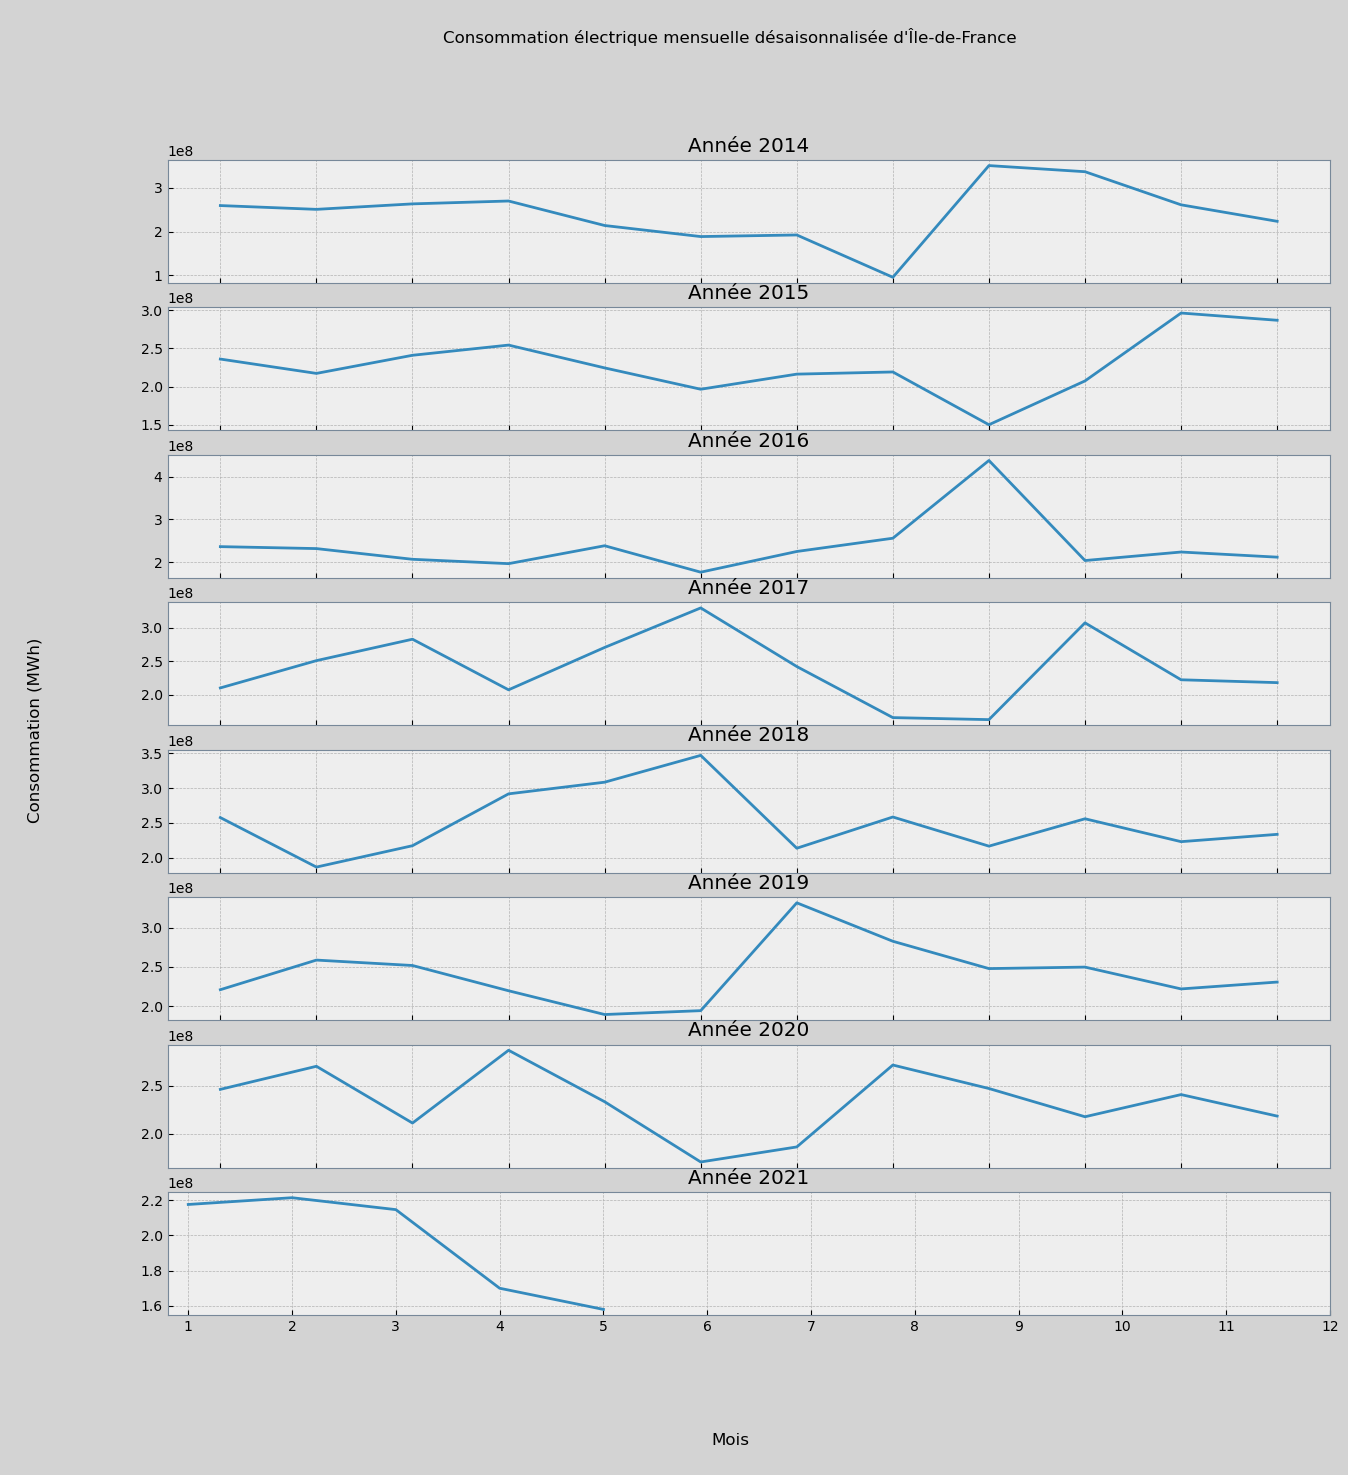

In [ ]:
# comparaison des années

# préparation du terrain
list_annee = conso_idf.index.year.unique().tolist()
taille = len(list_annee)
fig, ax = plt.subplots(8, 1, figsize = (15, 15))

# affichage pour chaque année
for i in range(taille):
    data = conso_idf[conso_idf.index.year == list_annee[i]]
    ax[i].plot(data.index.month, data.conso_dsais)
    ax[i].set_title('Année {}'.format(list_annee[i]))
    ax[i].label_outer()
    ax[i].set_xticks(np.arange(1, 13, 1)) # pour forcer l'affichage des 12 mois

fig.suptitle("\nConsommation électrique mensuelle désaisonnalisée d'Île-de-France\n\n")
fig.supxlabel('Mois\n')
fig.supylabel('\nConsommation (MWh)')
plt.show()

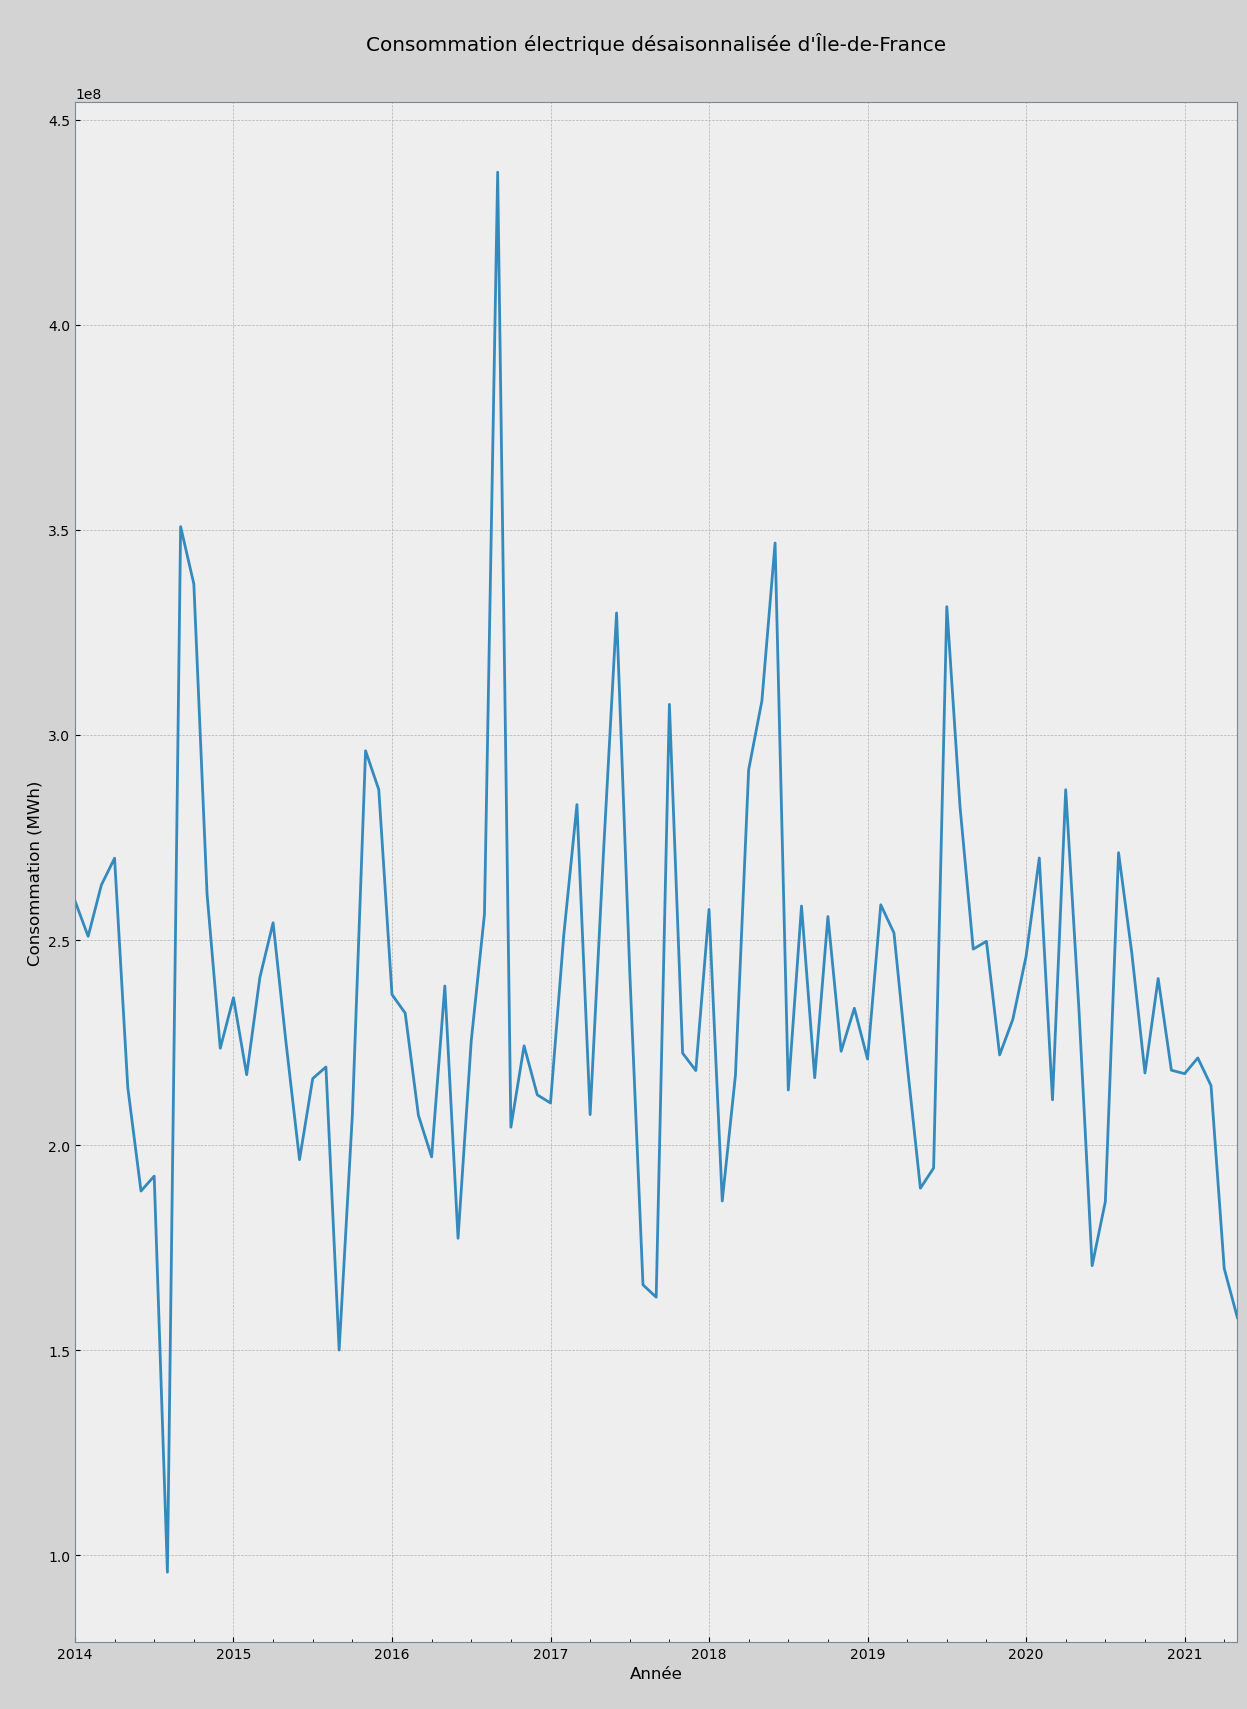

In [ ]:
# visualisation de la consommation désaisonnalisée
plt.figure(figsize = (15, 20))
conso_idf.conso_dsais.plot()
plt.title("\nConsommation électrique désaisonnalisée d'Île-de-France\n\n")
plt.xlabel('Année\n')
plt.ylabel('\nConsommation (MWh)')
plt.show()

**Observations:**  
- La consommation ne présente aucune tendance notable, nous venons également d'en extraire la saisonnalité. => Ce graphique représente les valeurs résiduelles de la consommation en Île-de-France.  
- De façon cyclique, la consommation subit une chute suivie d'une forte hausse dont la plus grande amplitude a eu lieu en 2014.  
- Les cycles de hausse sont répartis entre les mois estivaux et la rentrée, ce qui, en terme de cycle de vie correspond aux vacances (hausse du temps libre) et la reprise des activités à plein temps des entreprises. La consommation de 2021 n'en fait pas partie (valeurs mi-annuelles dans les normes).

#### [**4. Prévision de la consommation**](#table-des-matières)  
  
Dans cette partie, nous cherchons à prévoir la consommation électrique d'Île-de-France des 20 prochains mois. Cette période prend en compte les 12 mois de l'année 2022 ainsi que les 7 mois non pris en compte de 2020.  
  
Nous utilisons deux moyens de prévisions: la méthode de Holt-Winters et la méthode SARIMA.  

##### [**4.1 Méthode Holt-Winters**](#table-des-matières)  
  
Nous disposons de données ayant une légère tendance baissière à partir de 2018 ainsi qu'une version désaisonnalisée de la consommation. Puisque la méthode Holt-Winters prend en compte la tendance et la saisonnalité d'une série temporelle, nous pouvons directement l'appliquer sur les données corrigées non traitées de la consommation électrique.  
  
Nous commençons par affecter les paramètres de Holt-Winters. Ensuite, nous appliquons les deux versions de la méthode, additive et multiplicative et comparons leur efficacité à travers le calcul des écarts absolus au carré et moyen.  
Grâce à la vérification des hypothèses de régression linéaire, nous savons également que les observations ne sont pas générées par un processus stationnaire.

In [ ]:
conso_idf.tail(2)

,conso_mwh,date_n,conso_corr,mm,coeff_mm,coeff_ajus,conso_dsais
date,,,,,,,
2021-04-01,5562381.0,737881,5.988782e+07,2.179554e+08,0.274771,0.352388,1.699487e+08
2021-05-01,5092336.0,737911,8.654548e+07,2.145171e+08,0.403443,0.547979,1.579358e+08


In [ ]:
# application de la méthode Holt-Winters "additive" et "multiplicative"
conso_idf['conso_hw_add'] = ExponentialSmoothing(conso_idf.conso_corr, trend='add', seasonal='add', seasonal_periods=12).fit().fittedvalues
conso_idf['conso_hw_mul'] = ExponentialSmoothing(conso_idf.conso_corr, trend='mul', seasonal='mul', seasonal_periods=12).fit().fittedvalues

c:\Users\Dar_ia\miniconda3\envs\data-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Dar_ia\miniconda3\envs\data-py3.10\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\Dar_ia\miniconda3\envs\data-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Dar_ia\miniconda3\envs\data-py3.10\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


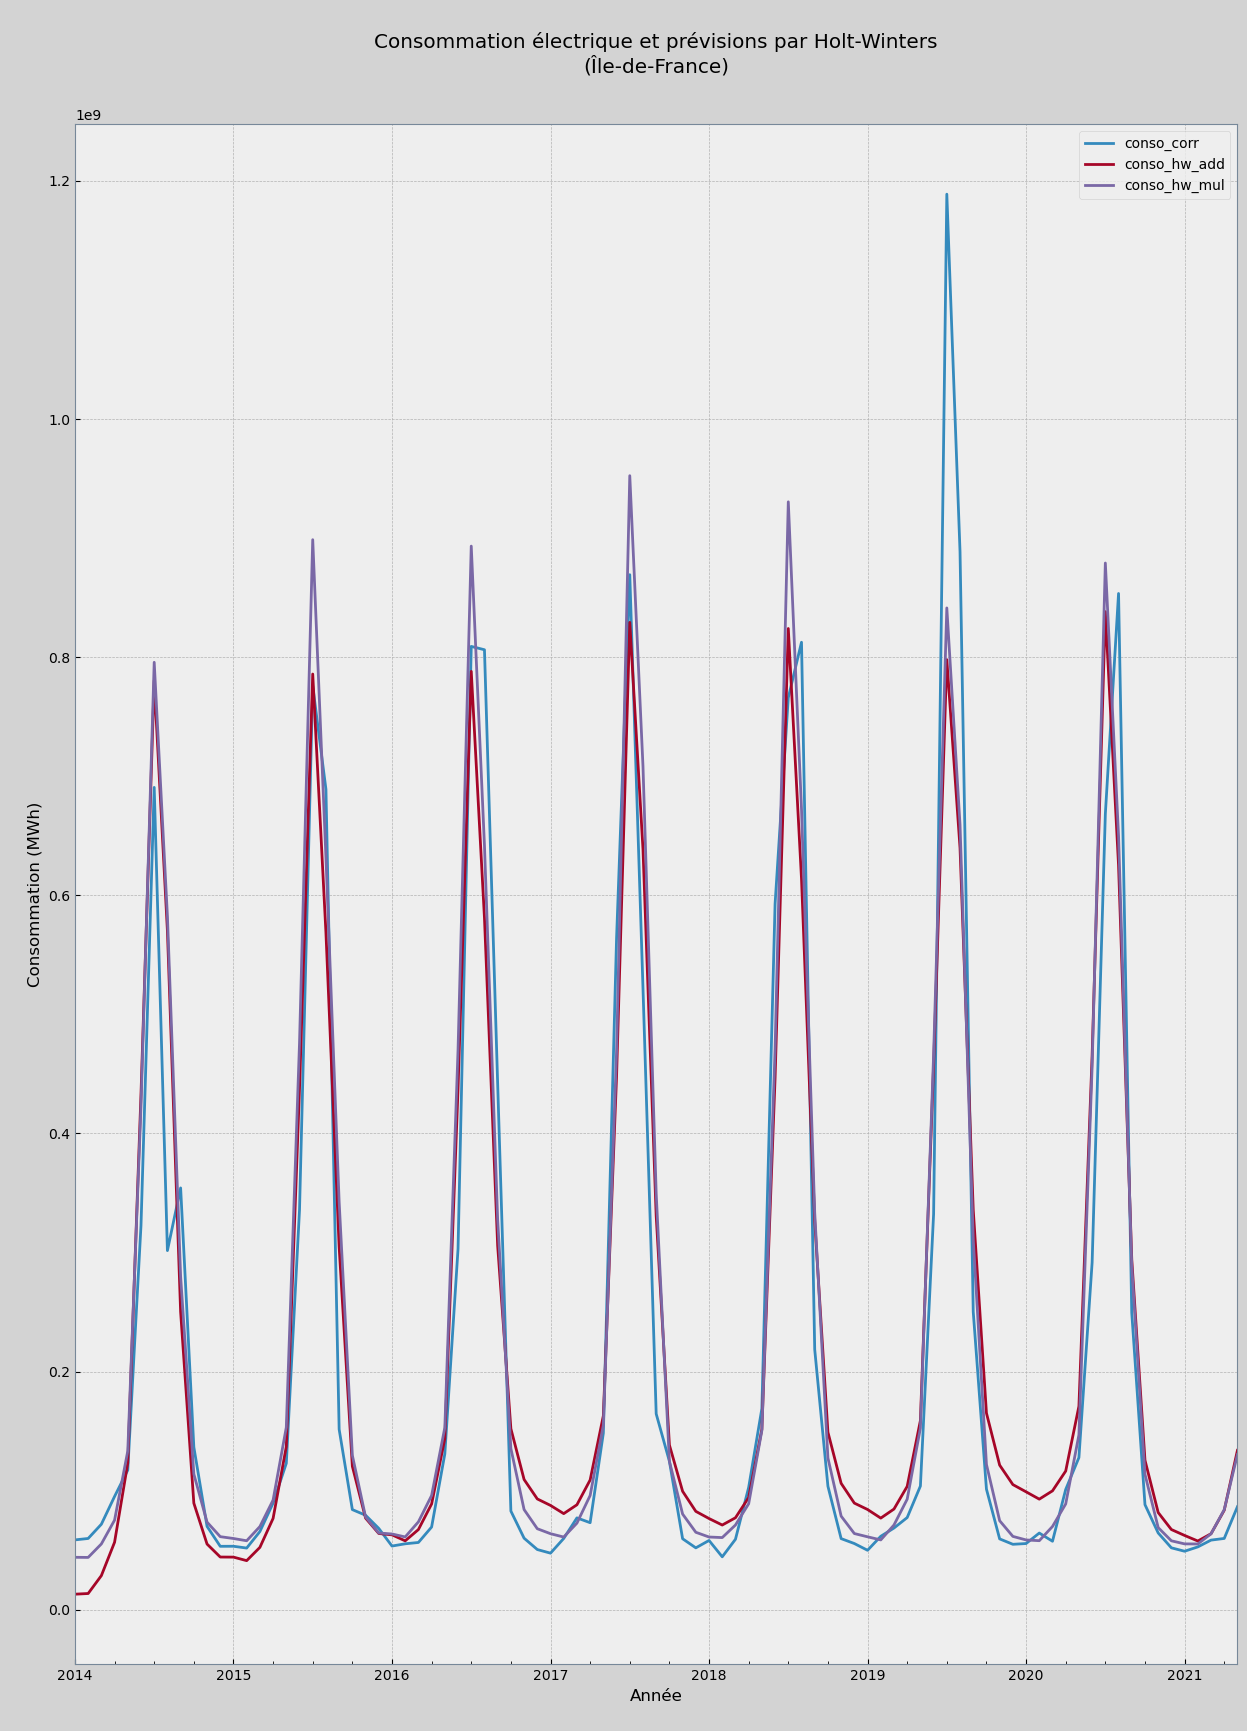

In [ ]:
# visualisation comparative de la consommation
plt.figure(figsize = (15, 20))

conso_idf.conso_corr.plot()
conso_idf.conso_hw_add.plot()
conso_idf.conso_hw_mul.plot()

plt.title("\nConsommation électrique et prévisions par Holt-Winters\n(Île-de-France)\n\n")
plt.xlabel('Année\n')
plt.ylabel('\nConsommation (MWh)')
plt.legend().set_visible(True)
plt.show()

La méthode Holt-Winters additive est plus adaptée pour l'évaluation des valeurs maximales tandis que l'approche multiplicative est plus fidèle aux faibles consommations.  
Évaluons mathématiquement ces différences.

In [ ]:
# calcul des écarts absolus et moyens pour l'addition Holt-Winters
mae_add = mean_absolute_error(conso_idf.conso_corr, conso_idf.conso_hw_add)
mse_add = mean_squared_error(conso_idf.conso_corr, conso_idf.conso_hw_add)

print('Pour le modèle additive:')
print('- Moyenne des écarts au carré = ', round(mse_add, 2))
print('- Ecart moyen =', round(mae_add, 2))

Pour le modèle additive:
- Moyenne des écarts au carré =  8816683143171903.0
- Ecart moyen = 62246597.53


In [ ]:
# calcul des écarts absolus et moyens pour la multiplication Holt-Winters
mae_mul = mean_absolute_error(conso_idf.conso_corr, conso_idf.conso_hw_mul)
mse_mul = mean_squared_error(conso_idf.conso_corr, conso_idf.conso_hw_mul)

print('Pour le modèle muliplicatif:')
print('- Moyenne des écarts au carré = ', round(mse_mul, 2))
print('- Ecart moyen =', round(mae_mul, 2))

Pour le modèle muliplicatif:
- Moyenne des écarts au carré =  8373480225376933.0
- Ecart moyen = 55837787.24


Globalement, le modèle multiplicative décrit plus fidèlement les données mais l'appréciation visuelle des écarts aux voisinages des valeurs minimales et maximales rendent cette déduction insatisfaisante.  
=> Pour les deux modèles, nous recalculons les écarts absolus et moyens par morceaux en utilisant la consommation médiane comme limite.

In [ ]:
# horizon des évènements... locaux
conso_mediane = conso_idf.conso_corr.median()

In [ ]:
# calcul des écarts pour les valeurs inférieures à la limite
mae_add_inf = mean_absolute_error(conso_idf[conso_idf.conso_corr <= conso_mediane].conso_corr, conso_idf[conso_idf.conso_corr <= conso_mediane].conso_hw_add)
mae_mul_inf = mean_absolute_error(conso_idf[conso_idf.conso_corr <= conso_mediane].conso_corr, conso_idf[conso_idf.conso_corr <= conso_mediane].conso_hw_mul)

print('Pour les valeurs inférieures à la médiane:')
print('- Ecart moyen "additif" =', round(mae_add_inf, 2))
print('- Ecart moyen "multiplicatif =', round(mae_mul_inf, 2))

Pour les valeurs inférieures à la médiane:
- Ecart moyen "additif" = 26770234.25
- Ecart moyen "multiplicatif = 13009313.78


In [ ]:
# calcul des écarts pour les valeurs supérieures à la limite
mae_add_sup = mean_absolute_error(conso_idf[conso_idf.conso_corr > conso_mediane].conso_corr, conso_idf[conso_idf.conso_corr > conso_mediane].conso_hw_add)
mae_mul_sup = mean_absolute_error(conso_idf[conso_idf.conso_corr > conso_mediane].conso_corr, conso_idf[conso_idf.conso_corr > conso_mediane].conso_hw_mul)

print('Pour les valeurs supérieures à la médiane:')
print('- Ecart moyen "additif" =', round(mae_add_sup, 2))
print('- Ecart moyen "multiplicatif =', round(mae_mul_sup, 2))

Pour les valeurs supérieures à la médiane:
- Ecart moyen "additif" = 98529241.79
- Ecart moyen "multiplicatif = 99639635.1


Comme pressenti, l'utilisation des deux modèles est pertinente pour décrire les observations selon la plage des valeurs.  
=> Nous choisissons d'utiliser les deux modèles pour prédire, par morceaux, la consommation électrique:  
- consommation > médiane => modèle additif;  
- consommation <= médiane => modèle multiplicatif.

In [ ]:
# prédictions "additive" pour les 20 prochains mois
prevision_hw_add = ExponentialSmoothing(conso_idf.conso_corr, trend='mul', seasonal='mul', seasonal_periods=12).fit()
conso_prevue_add = prevision_hw_add.forecast(20)

c:\Users\Dar_ia\miniconda3\envs\data-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Dar_ia\miniconda3\envs\data-py3.10\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [ ]:
# prédictions "multiplicative" des 20 prochains mois
prevision_hw_mul = ExponentialSmoothing(conso_idf.conso_corr, trend='mul', seasonal='mul', seasonal_periods=12).fit()
conso_prevue_mul = prevision_hw_mul.forecast(20)

c:\Users\Dar_ia\miniconda3\envs\data-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Dar_ia\miniconda3\envs\data-py3.10\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [ ]:
# construction des prédictions générales par morceaux selon la limite médiane
conso_prevue = conso_prevue_add[conso_prevue_add > conso_mediane]
conso_prvue = pd.concat([conso_prevue, conso_prevue_mul[conso_prevue_mul <= conso_mediane]])

In [ ]:
conso_prevue.sort_index(inplace = True)

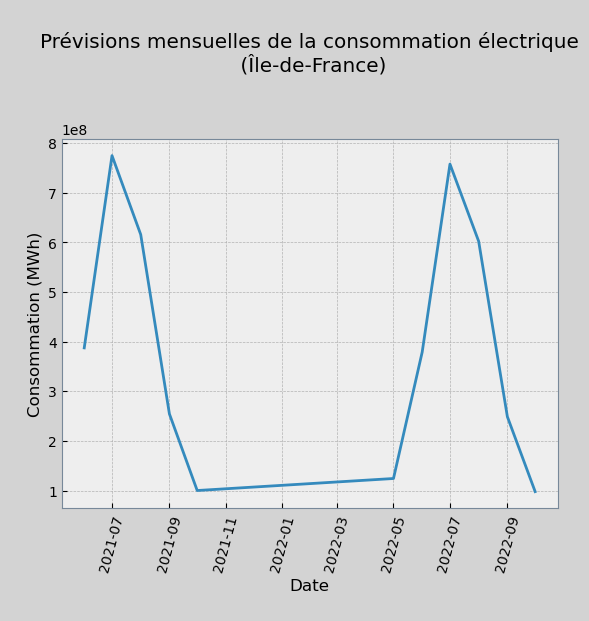

In [ ]:
# graphique de la consommation prédite
plt.plot(conso_prevue)
plt.title("\nPrévisions mensuelles de la consommation électrique\n (Île-de-France)\n\n")
plt.xlabel('Date\n')
plt.ylabel('\nConsommation (MWh)')
plt.xticks(rotation = 75)
plt.show()

Nous retrouvons les effets de saisonnalité avec des valeurs maximales au voisinage des mois estivaux dans les normes des années précédentes. La consommation est bien sans tendance perceptible.

##### [**4.2 Méthode SARIMA**](#table-des-matières)  
  
Le modèle SARIMA nous permet de gérer la tendance et la saisonnalité d'une distribution mais cette dernière doit répondre aux principes de stationnarité, ce qui n'est pas notre cas.  
  
Donc nous commençons par rendre la série temporelle stationnaire puis nous appliquons le modèle SARIMA afin de prévoir la consommation des 20 prochains mois.  
  
##### [**4.2.1 Stationnarité**](#table-des-matières)  
  
Nous commençons par déterminer proprement le type de non-stationnarité du processus. Ensuite, nous choisissons la méthode de stationnarité et transformons la série.  

**o Etape 1/2a: test de stationnarité - ADF**  
  
Environnement de test:  
~ H0: la série temporelle de la consommation électrique n'est pas stationnaire;  
~ Ha: la consommation est engendrée par un processus stationnaire;  
~ Risque d'erreur 5%;
  
~ Condition de rejet de H0: p-value(test) < risque d'erreur.

In [ ]:
test_adf = adfuller(conso_idf.conso_corr)
print("Statistique ADF: %f" % test_adf[0])
print("P_value ADF: %f" % test_adf[1])
print("Valeurs critiques:")
for key, value in test_adf[4].items():
	print('\t%s: %.3f' % (key, value))

Statistique ADF: -1.971300
P_value ADF: 0.299297
Valeurs critiques:
	1%: -3.519
	5%: -2.900
	10%: -2.587


La statistique de test ADF est négative et supérieure à la valeur critique de 5% => nous ne pouvons rejeter l'hypothèse de nullité.  
=> La série est considérée non-stationnaire.

**o Etape 1/2b: test de stationnarité - KPSS**  
  
Environnement de test:  
~ H0: la série temporelle est tendance-stationnaire (TS);  
~ Ha: la série n'est pas stationnaire;  
~ Risque d'erreur: 1%;  
  
~ Condition de rejet de H0: p_value(KPSS) < 0.05.

In [ ]:
test_kpss = kpss(conso_idf.conso_corr, regression = 'ct')
print("Statistique KPSS:", test_kpss[0])
print("P_value KPSS:", test_kpss[1])
print("Valeurs critiques:")
for key, value in test_kpss[3].items():
	print('\t%s: %.3f' % (key, value))

Statistique KPSS: 0.03233064954310547
P_value KPSS: 0.1
Valeurs critiques:
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


C:\Users\Dar_ia\AppData\Local\Temp\ipykernel_9952\857841646.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  test_kpss = kpss(conso_idf.conso_corr, regression = 'ct')


La statistique KPSS est nettement inférieure à la valeur critique 0.216 de 1% et p_value > 1%.  
=> Avec un risque de première espèce confortablement bas, nous choisissons de ne pas rejeter H0.  
=> Nous en déduisons que la série temporelle n'a pas de racine unitaire.  
=> La série est tendance-stationnaire.  
  
**o Etape 2/2: stationnarité**  
  
Nous avons:  
~ test ADF: la série n'est pas stationnaire;  
~ test KPSS: la série est tendance-stationnaire (TS).  
=> Pour transformer une série TS en processus stationnaire strict, il nous faut supprimer la tendance. Pour traiter un tel cas, nous devons utiliser la méthode de régression linéaire.  
  
Nous commençons par entraîner un modèle de régression linéaire sur les dates et les données de consommation corrigées. Nous enregistrons les données prédites avec le modèle. Nous les soustrayons aux données corrigées d'origine afin de récupérer leur version sans tendance. Puis nous refaisons un test ADF afin de vérifier le traitement effectif de la stationnarité.

In [ ]:
# préparation locale des données
x = np.array(conso_idf.date_n)
y = np.array(conso_idf.conso_corr)

x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

In [ ]:
# déclaration et entraînement du modèle
model_lr = LinearRegression()
model_lr.fit(x, y)

LinearRegression()

In [ ]:
# prédiction du modèle
conso_idf['conso_predit_rl'] = model_lr.predict(x)

In [ ]:
# calcul des valeurs détendanciées
conso_idf['conso_dtrend'] = conso_idf['conso_corr'] - conso_idf['conso_predit_rl']

In [ ]:
model = OLS(y, x).fit()

In [ ]:
detrend = conso_idf.conso_corr - model.predict(x)

In [ ]:
test_adf = adfuller(detrend)
print("Statistique ADF:", test_adf[0])
print("P_value ADF:", test_adf[1])
print("Valeurs critiques:")
for key, value in test_adf[4].items():
	print('\t%s: %.3f' % (key, value))

Statistique ADF: -1.9694260649157553
P_value ADF: 0.3001374588046872
Valeurs critiques:
	1%: -3.519
	5%: -2.900
	10%: -2.587


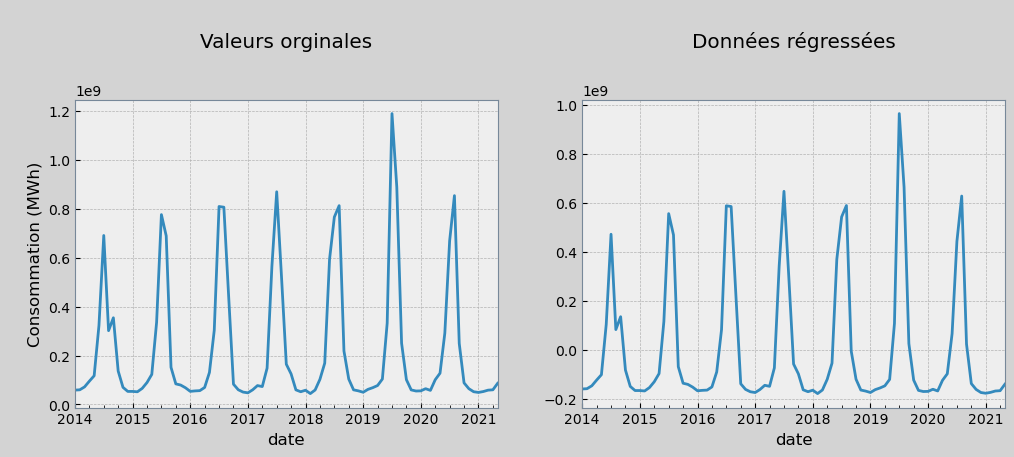

In [ ]:
# visualisation de la conso détendanciée
ax1 = plt.subplot(121)
conso_idf.conso_corr.plot(figsize=(12,4), title = "\nValeurs orginales\n\n", ax = ax1, ylabel = '\nConsommation (MWh)')
ax2 = plt.subplot(122)
conso_idf.conso_dtrend.plot(figsize=(12,4), title = "\nDonnées régressées\n\n", ax = ax2)

plt.show()

Initialement, la tendance était difficilement perceptible à l'oeil nu => les modifications sont tout autant discrètes.  
Nous refaisons un test ADF.

In [ ]:
# test ADF sur les valeurs traitées
test_adf = adfuller(conso_idf.conso_dtrend, regression = 'n')
print("Statistique ADF:", test_adf[0])
print("P_value ADF:", test_adf[1])
print("Valeurs critiques:")
for key, value in test_adf[4].items():
	print('\t%s: %.3f' % (key, value))

Statistique ADF: -1.5781819754062978
P_value ADF: 0.10783259335259221
Valeurs critiques:
	1%: -2.596
	5%: -1.945
	10%: -1.614


La p_value reste supérieure à 5% donc nous ne pouvons rejeter l'hypothèse de nullité. Nous ne pouvons que conclure à la nature non-stationnaire de la série et à l’inefficacité de son traitement par régression linéaire.  
Ce résultat étant surprenant, nous choisissons d'utiliser une fonction Stastmodels de décomposition de la série.

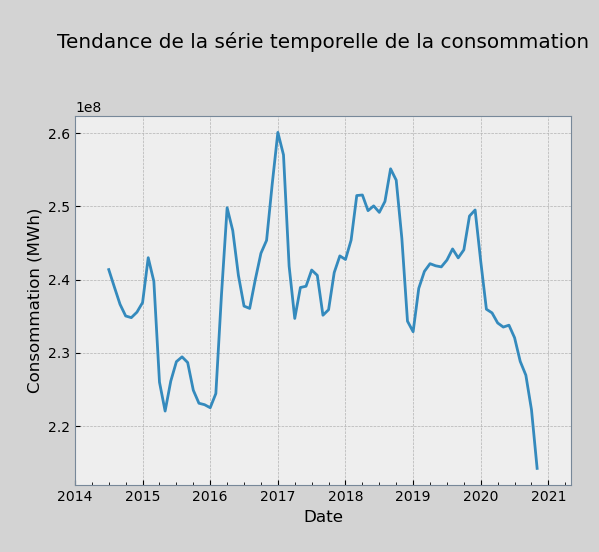

In [ ]:
decomposition = seasonal_decompose(conso_idf.conso_dsais)
decomposition.trend.plot()
plt.title('\nTendance de la série temporelle de la consommation\n\n')
plt.xlabel('Date\n')
plt.ylabel('\nConsommation (MWh)')
plt.show()

Cette décomposition nous prouve que la tendance ait correctement été traitée. Une erreur d'interprétation du test ADF nous a conduit à une mauvaise conclusion.  
  
La série temporelle est prête. Nous passons à la prédiction des 20 prochains par la méthode SARIMA.

##### [**4.2.2 SARIMA**](#table-des-matières)

In [ ]:
# paramétrage de la modélisation
order_ = (1, 1, 1)
seasonal_order_ = (1, 1, 1, 12)

In [ ]:
# déclaration + entraînement
model = SARIMAX(conso_idf.conso_dtrend, order = order_, seasonal_order = seasonal_order_).fit()

c:\Users\Dar_ia\miniconda3\envs\data-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Dar_ia\miniconda3\envs\data-py3.10\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
# prédiction de la conso. pour les dates existantes
prediction = model.predict(20)

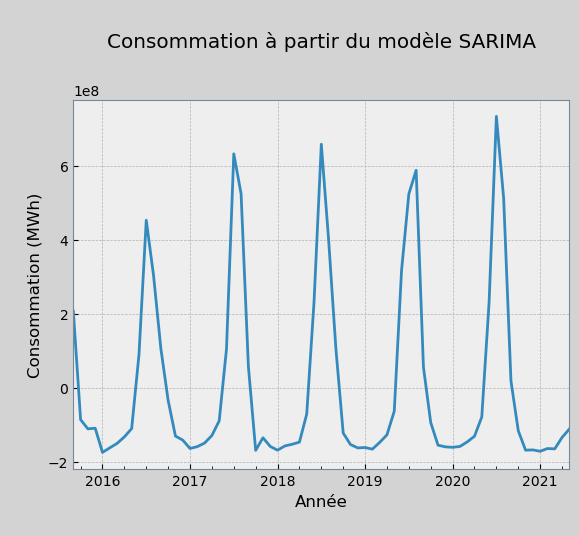

In [ ]:
# visualisation de la consommation SARIMA
prediction.plot()
plt.title('\nConsommation à partir du modèle SARIMA\n\n')
plt.xlabel('Année\n')
plt.ylabel('\nConsommation (MWh)')
plt.show()

In [ ]:
# écarts absolus et moyens entre la conso réelle et la conso. SARIMA
rmae = mean_absolute_error(conso_idf[conso_idf.index.isin(prediction.index)].conso_dtrend, prediction)
rmse = mean_squared_error(conso_idf[conso_idf.index.isin(prediction.index)].conso_dtrend, prediction)

print('RMAE =', rmae)
print('RMSE =', rmse)

RMAE = 61451402.921802334
RMSE = 1.1491195142876584e+16


In [ ]:
# rappel des écarts du modèle Holt-Winters
mae_add = mean_absolute_error(conso_idf.conso_corr, conso_idf.conso_hw_add)
mse_add = mean_squared_error(conso_idf.conso_corr, conso_idf.conso_hw_add)

print('Pour le modèle additive:')
print('- Moyenne des écarts au carré = ', round(mse_add, 2))
print('- Ecart moyen =', round(mae_add, 2))

Pour le modèle additive:
- Moyenne des écarts au carré =  8816683143171903.0
- Ecart moyen = 62246597.53


L'ordre de grandeur de l'écart moyen au carré du modèle SARIMA est largement supérieur à celui de Holt-Winters.  
=> La méthode Holt-Winters est plus adaptée pour décrire et par extension, pour prédire la consommation électrique.  
Néanmoins, nous poursuivons avec les prévisions du modèle SARIMA conformément à la problématique. Simplement, si des estimations devaient être utilisées, nous savons que les prévisions Holt-Winters seraient celles qu'il faut exploiter.

In [ ]:
# prévisions SARIMA de la consommation
prevision = model.forecast(20)

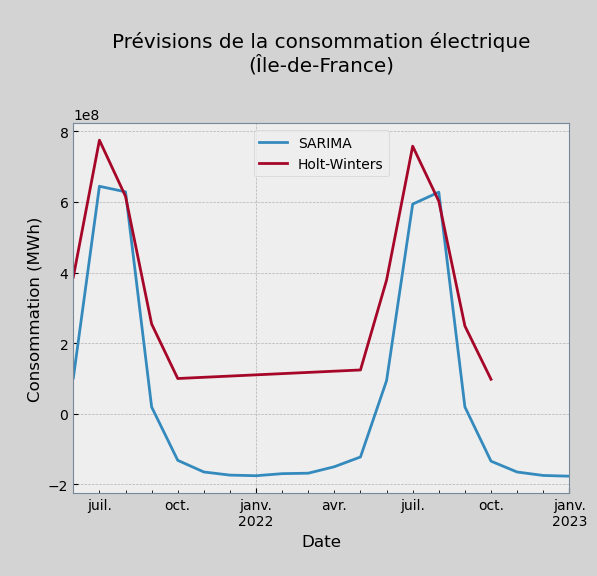

In [ ]:
# visualisation de la consommation SARIMA + Holt-Winters
prevision.plot()
conso_prevue.plot()

plt.title('\nPrévisions de la consommation électrique\n(Île-de-France)\n\n')
plt.legend(['SARIMA', 'Holt-Winters'], loc='upper center')
plt.xlabel('Date\n')
plt.ylabel('\nConsommation (MWh)')
plt.show()

Les prévisions SARIMA est cohérent avec une saisonnalité marquée et une tendance imperceptible. Les valeurs maximales sont dans un bon ordre de grandeur.  
  
Néanmoins, les légères incidences des maximums sont gonflées par SARIMA prévoyant ainsi des consommations maximales bimodales. Mais l'anomalie la plus importante du modèle réside dans les prévisions minimales.  
  
Cette étude concerne la consommation et non les flux d'énergie. De plus, si dans l'hypothèse, nous pourrions considérer les énergies produites par la population elle-même (par les panneaux solaires, par ex.), ce modèle n'est calibré pour prendre en compte ces données et une telle production est majoritairement directement consommé par le producteur et la redistribution du restant ne pourrait représenter un quart de la consommation totale. Par conséquent, nous ne devrions pas avoir de valeurs négatives.  
  
Soit nous sommes dans un défaut de maîtrise du paramétrage soit la méthode est simplement inadéquate dans ce contexte. Si nous devions exploiter des données prévisionnelles, il nous faudrait utiliser celles engendrées par Holt-Winters.